# **<center>Yoga Pose Classification</center>**

### **Library Loading**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

import torchvision
from torchvision import datasets, models, transforms

from timeit import default_timer as timer

In [2]:
ls

__notebook__.ipynb


### **Checking for data imbalance**

In [3]:
classes = ['Downdog', 'Goddess', 'Plank', 'Tree','Warrior2']

In [4]:
def data_count(main_path = '../input/yoga-pose-classification/YogaPoses/'):
    counts = {}
    for root,dirs,files in os.walk(main_path):
        if files != [] and str(root.split('/')[-1]) in classes:
            counts[str(root.split('/')[-1])] = len(files)
    return counts

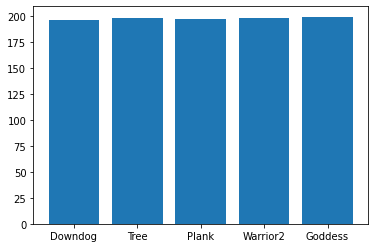

In [5]:
counts = data_count()
plt.bar(list(counts.keys()),list(counts.values()))
plt.show()

We shall split the data into training (70%) and validation (30%) maintainig the class balance.

### **Train-Valid Split**

In [6]:
def data_split(main_path = '../input/yoga-pose-classification/YogaPoses/', split_percentage = 0.3):
    train_dict = {}
    valid_dict = {}
    counts = data_count(main_path)
    for root,dirs,files in os.walk(main_path):
        if files != [] and str(root.split('/')[-1]) in ['Downdog', 'Goddess', 'Plank', 'Tree','Warrior2']:
            file_paths = [os.path.join(root,files[i]) for i in range(len(files))]
            
            valid_idxs = np.random.randint(low=0,high=len(files),size=int(len(files)*split_percentage))
            train_idxs = list(set(range(0,len(files))) - set(valid_idxs))
            
            train_dict[str(root.split('/')[-1])] = [file_paths[idx] for idx in train_idxs]
            valid_dict[str(root.split('/')[-1])] = [file_paths[idx] for idx in valid_idxs]
            
    return train_dict, valid_dict

In [7]:
train_dict, valid_dict = data_split()

In [8]:
def visualize(data_dict):    
    idx = np.random.randint(0,min(list([len(l) for l in data_dict.values()])))

    plt.figure(figsize=(20,6))
    plt.subplot(161)
    plt.imshow(cv2.imread(train_dict['Downdog'][idx]).astype(int))
    plt.title('Downdog')
    plt.subplot(162)
    plt.imshow(cv2.imread(train_dict['Goddess'][idx]).astype(int))
    plt.title('Goddess')
    plt.subplot(163)
    plt.imshow(cv2.imread(train_dict['Plank'][idx]).astype(int))
    plt.title('Plank')
    plt.subplot(164)
    plt.imshow(cv2.imread(train_dict['Tree'][idx]).astype(int))
    plt.title('Tree')
    plt.subplot(165)
    plt.imshow(cv2.imread(train_dict['Warrior2'][idx]).astype(int))
    plt.title('Warrior2')


    plt.show()

In [9]:
train_dict.keys()

dict_keys(['Downdog', 'Tree', 'Plank', 'Warrior2', 'Goddess'])

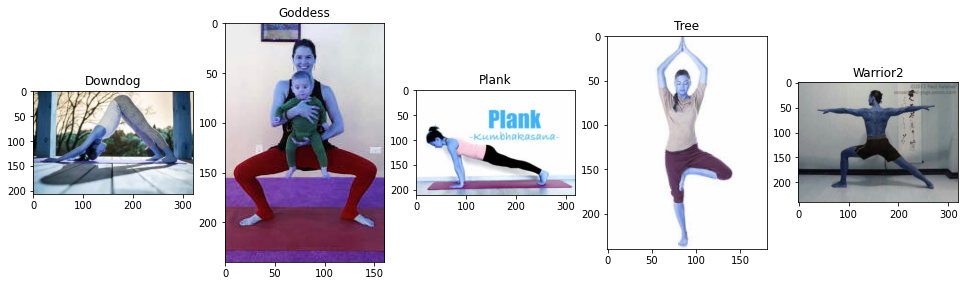

In [10]:
# training data
visualize(train_dict)

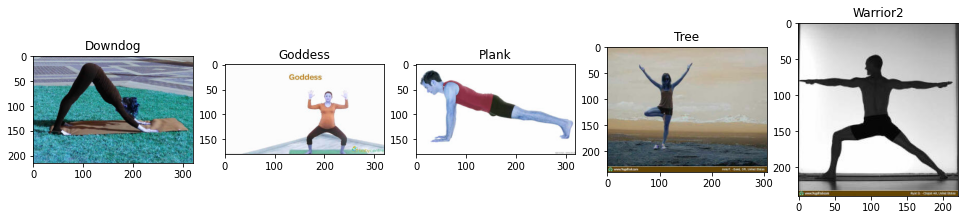

In [11]:
# validation data
visualize(valid_dict)

In [12]:
print('training data sizes : ', [len(l) for l in train_dict.values()])
print('validation data sizes : ', [len(l) for l in valid_dict.values()])

training data sizes :  [144, 146, 147, 151, 150]
validation data sizes :  [58, 59, 59, 59, 59]


In [13]:
## dataset class

class YogaData(Dataset):
    """Chess Piece Dataset class"""
    
    def __init__(self, data_dict, transform=None):
        """
        Args:
            data_dict (dict): dictionary with class as key and the corresponding paths to the data of that class 
        """
        self.data_dict = data_dict
        self.transform = transform
        
    def __len__(self):
        return sum([len(l) for l in self.data_dict.values()])
    
    def __getitem__(self,idx):
        counts = [len(l) for l in self.data_dict.values()]
        sum_counts = list(np.cumsum(counts))
        sum_counts = [0] + sum_counts + [np.inf]
        
        for c,v in enumerate(sum_counts):
            if idx < v:
                i = (idx - sum_counts[c-1]) - 1
                break
        #print(c,i,idx)
        label = list(self.data_dict.keys())[c-1]
        img = Image.open(self.data_dict[str(label)][i]).convert('RGB')
        if self.transform:
            img = self.transform(img)
            
        return img, classes.index(str(label))

As the number of data per class is not too much, so data augmentation plays a vital role in here.

In [14]:
#  data augmentation

data_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.RandomVerticalFlip(),
                                     transforms.RandomAdjustSharpness(sharpness_factor=1.5),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ColorJitter(),
                                     transforms.Resize((224,224))])

data_train = YogaData(train_dict,transform = data_transform)
data_valid = YogaData(valid_dict,transform = data_transform)

Total Number of training images :  738
Total Number of validation images :  294


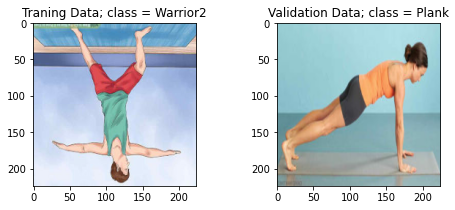

In [15]:
t_idx = np.random.randint(0,len(data_train))
v_idx = np.random.randint(0,len(data_valid))

print("Total Number of training images : ", len(data_train))
print("Total Number of validation images : ", len(data_valid))

t_img,t_label = data_train[t_idx]
v_img,v_label = data_valid[v_idx]

plt.figure(figsize=(8,3))
plt.subplot(121)
plt.imshow(t_img.numpy().transpose(1,2,0))
plt.title(f'Traning Data; class = {classes[t_label]}')
plt.subplot(122)
plt.imshow(v_img.numpy().transpose(1,2,0))
plt.title(f'Validation Data; class = {classes[v_label]}')
plt.show()

In [16]:
# definning data loader

train_loader = DataLoader(data_train, batch_size=50, shuffle=True)
valid_loader = DataLoader(data_valid, batch_size=50, shuffle=True)

In [17]:
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched[0].size(),sample_batched[1])
    print(type(sample_batched[0]))
    break

0 torch.Size([50, 3, 224, 224]) tensor([2, 2, 1, 2, 1, 1, 3, 1, 3, 0, 0, 2, 2, 1, 3, 0, 0, 1, 2, 4, 2, 1, 3, 1,
        3, 1, 4, 2, 4, 4, 3, 2, 2, 4, 4, 3, 4, 3, 4, 3, 0, 0, 0, 2, 3, 3, 2, 1,
        1, 3])
<class 'torch.Tensor'>


In [18]:
# definnig the loss function

import torch.optim as optim
import torch.nn as nn

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

we are using the binary cross entropy loss here and as we are going to use the ResNet architechture the loss surface is going to be rough and messy. Lets see which optimizer gives the best result.

### **Model define**

In [19]:
#Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# print out the model structure
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [20]:
print(vgg16.classifier[6].in_features) 
print(vgg16.classifier[6].out_features)

4096
1000


In [21]:
# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False

In [22]:
n_inputs = vgg16.classifier[6].in_features

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

vgg16.classifier[6] = last_layer

# if GPU is available, move the model to GPU
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print("training on gpu...")
    vgg16.cuda()
else:
    print("no gpu found.")

# check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)
print(vgg16)

training on gpu...
5
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, 

In [23]:
def base_model_build():
    #Load the pretrained model from pytorch
    vgg16 = models.vgg16(pretrained=True)

    # print out the model structure
    #print(vgg16)
    
    # Freeze training for all "features" layers
    for param in vgg16.features.parameters():
        param.requires_grad = False
        
    import torch.nn as nn

    n_inputs = vgg16.classifier[6].in_features

    # add last linear layer (n_inputs -> 5 flower classes)
    # new layers automatically have requires_grad = True
    last_layer = nn.Linear(n_inputs, len(classes))

    vgg16.classifier[6] = last_layer

    # if GPU is available, move the model to GPU
    train_on_gpu = torch.cuda.is_available()
    if train_on_gpu:
        print("training on gpu...")
        vgg16.cuda()
    else:
        print("no gpu found.")

    # check to see that your last layer produces the expected number of outputs
    #print(vgg16.classifier[6].out_features)
    #print(vgg16)
    
    return vgg16


def loss_acc_visuaize(history,optim,path):
    plt.figure(figsize=(20,10))

    plt.suptitle(str(optim))

    plt.subplot(121)
    plt.plot(history['train_loss'],label='train_loss')
    plt.plot(history['valid_loss'],label='valid_loss')
    plt.legend()
    plt.title('Loss Curves')

    plt.subplot(122)
    plt.plot(history['train_acc'],label='train_acc')
    plt.plot(history['valid_acc'],label='valid_acc')
    plt.legend()
    plt.title('Accuracy Curves')
    
    plt.savefig(str(path) + 'loss_acc.png')


def grad_visualize(history,optim,path,ylimit=10):
    # gadient norm distribution

    import seaborn as sns

    plt.figure(figsize=(20,10))

    plt.suptitle(str(optim))

    plt.subplot(131)
    sns.kdeplot(weight_grads1, shade=True)
    sns.kdeplot(bias_grads1, shade=True)
    plt.legend(['weight','bias'])
    plt.title('Linear layer 1')
    #plt.gca().set_xlim(left=0)
    plt.ylim(0,ylimit)

    plt.subplot(132)
    sns.kdeplot(weight_grads2, shade=True)
    sns.kdeplot(bias_grads2, shade=True)
    plt.legend(['weight','bias'])
    plt.title('Linear layer 2')
    #plt.gca().set_xlim(left=0)
    plt.ylim(0,ylimit)

    plt.subplot(133)
    sns.kdeplot(weight_grads3, shade=True)
    sns.kdeplot(bias_grads3, shade=True)
    plt.legend(['weight','bias'])
    plt.title('Linear layer 3')
    #plt.gca().set_xlim(left=0)
    plt.ylim(0,ylimit)
    
    plt.savefig(str(path) + 'grad_norms.png')
    

def visual_predict(model,data=data_valid):
    c = np.random.randint(0,len(data))
    img, label = data[c]

    with torch.no_grad():
            model.eval()
            # Model outputs log probabilities
            out = model(img.view(1,3,224,224).cuda())
            out = torch.exp(out)
            print(out)

    plt.figure(figsize = (10,5))
    plt.subplot(121)
    plt.imshow(img.numpy().transpose((1,2,0)))
    plt.title(str(classes[label]))
    plt.subplot(122)
    plt.barh(classes,out.cpu().numpy()[0])

    plt.show()
    

def class_accuracies(model,data_dict=valid_dict,classes=classes):
    accuracy_dict = {}
    with torch.no_grad():
        model.eval()
        for c in data_dict.keys():
            correct_count = 0
            total_count = len(data_dict[str(c)])
            gt = classes.index(str(c))
            for path in data_dict[str(c)]:
                #print(path)
                im = Image.open(path).convert('RGB')
                #im.show()
                im = transforms.ToTensor()(im)
                im = transforms.Resize((224,224))(im)
                out = model(im.view(1,3,224,224).cuda())
                #print(out)
                out = torch.exp(out)
                pred = list(out.cpu().numpy()[0])
                #print(pred)
                pred = pred.index(max(pred))
                #print(pred,gt)

                if gt == pred:
                    correct_count += 1
            print(f"Accuracy for class {str(c)} : ",correct_count/total_count)
            accuracy_dict[str(c)] = correct_count/total_count
    return accuracy_dict

## **SGD**

In [24]:
vgg16=base_model_build()
optimizer_sgd = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

model=vgg16
criterion=criterion
optimizer=optimizer_sgd
train_loader=train_loader
valid_loader=valid_loader
save_file_name='../vgg16-transfer-sgd-lr=0.001'
max_epochs_stop=5
n_epochs=40
print_every=1

"""Train a PyTorch Model

Params
--------
    model (PyTorch model): cnn to train
    criterion (PyTorch loss): objective to minimize
    optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
    train_loader (PyTorch dataloader): training dataloader to iterate through
    valid_loader (PyTorch dataloader): validation dataloader used for early stopping
    save_file_name (str ending in '.pt'): file path to save the model state dict
    max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
    n_epochs (int): maximum number of training epochs
    print_every (int): frequency of epochs to print training stats

Returns
--------
    model (PyTorch model): trained cnn with best weights
    history (DataFrame): history of train and validation loss and accuracy
"""

# Early stopping intialization
epochs_no_improve = 0
valid_loss_min = np.Inf

valid_max_acc = 0
history = []
bias_grads1 = []
weight_grads1 = []
bias_grads2 = []
weight_grads2 = []
bias_grads3 = []
weight_grads3 = []


# Number of epochs already trained (if using loaded in model weights)
try:
    print(f'Model has been trained for: {model.epochs} epochs.\n')
except:
    model.epochs = 0
    print(f'Starting Training from Scratch.\n')

overall_start = timer()

# Main loop
for epoch in range(n_epochs):

    # keep track of training and validation loss each epoch
    train_loss = 0.0
    valid_loss = 0.0

    train_acc = 0
    valid_acc = 0

    # Set to training
    model.train()
    start = timer()

    # Training loop
    for ii, (data, target) in enumerate(train_loader):
        # Tensors to gpu
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Clear gradients
        optimizer.zero_grad()
        # Predicted outputs are log probabilities
        output = model(data)

        # Loss and backpropagation of gradients
        loss = criterion(output, target)
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        weight_grads1.append(np.linalg.norm(model.classifier[0].weight.grad.cpu().numpy()))
        bias_grads1.append(np.linalg.norm(model.classifier[0].bias.grad.cpu().numpy()))
        weight_grads2.append(np.linalg.norm(model.classifier[3].weight.grad.cpu().numpy()))
        bias_grads2.append(np.linalg.norm(model.classifier[3].bias.grad.cpu().numpy()))
        weight_grads3.append(np.linalg.norm(model.classifier[6].weight.grad.cpu().numpy()))
        bias_grads3.append(np.linalg.norm(model.classifier[6].bias.grad.cpu().numpy()))



        # Track train loss by multiplying average loss by number of examples in batch
        train_loss += loss.item() * data.size(0)

        # Calculate accuracy by finding max log probability
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        # Need to convert correct tensor from int to float to average
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples in batch
        train_acc += accuracy.item() * data.size(0)

        # Track training progress
        print(
            f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
            end='\r')

    # After training loops ends, start validation
    else:
        model.epochs += 1

        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for data, target in valid_loader:
                # Tensors to gpu
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                # Forward pass
                output = model(data)

                # Validation loss
                loss = criterion(output, target)
                # Multiply average loss times the number of examples in batch
                valid_loss += loss.item() * data.size(0)

                # Calculate validation accuracy
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))
                # Multiply average accuracy times the number of examples
                valid_acc += accuracy.item() * data.size(0)

            # Calculate average losses
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)

            # Calculate average accuracy
            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(valid_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            # Print training and validation results
            if (epoch + 1) % print_every == 0:
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                )

            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                # Save model
                torch.save(model.state_dict(), save_file_name)
                # Track improvement
                epochs_no_improve = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                # Trigger early stopping
                if epochs_no_improve >= max_epochs_stop:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                    )
                    total_time = timer() - overall_start
                    print(
                        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                    )

                    # Load the best state dict
                    model.load_state_dict(torch.load(save_file_name))
                    # Attach the optimizer
                    model.optimizer = optimizer

                    # Format history
                    history = pd.DataFrame(
                        history,
                        columns=[
                            'train_loss', 'valid_loss', 'train_acc',
                            'valid_acc'
                        ])
                    break

# Attach the optimizer
model.optimizer = optimizer
# Record overall time and print out stats
total_time = timer() - overall_start
print(
    f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
)
print(
    f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
)
# Format history
history = pd.DataFrame(
    history,
    columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

training on gpu...
Starting Training from Scratch.

Epoch: 0	100.00% complete. 21.43 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 1.6037 	Validation Loss: 1.4837
		Training Accuracy: 26.69%	 Validation Accuracy: 45.24%
Epoch: 1	100.00% complete. 12.35 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 1.4577 	Validation Loss: 1.3398
		Training Accuracy: 37.94%	 Validation Accuracy: 62.93%
Epoch: 2	100.00% complete. 11.52 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 1.3548 	Validation Loss: 1.2293
		Training Accuracy: 46.61%	 Validation Accuracy: 73.47%
Epoch: 3	100.00% complete. 11.84 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 1.2185 	Validation Loss: 1.1340
		Training Accuracy: 55.56%	 Validation Accuracy: 74.83%
Epoch: 4	100.00% complete. 11.50 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 1.1219 	Validation Loss: 1.0447
		Training Accuracy: 63.82%	 Validation Accuracy: 81.29%
Epoch: 5	100.00% complete. 11.63 seconds elapsed in epoch.
Epoch: 5 	Training Loss:

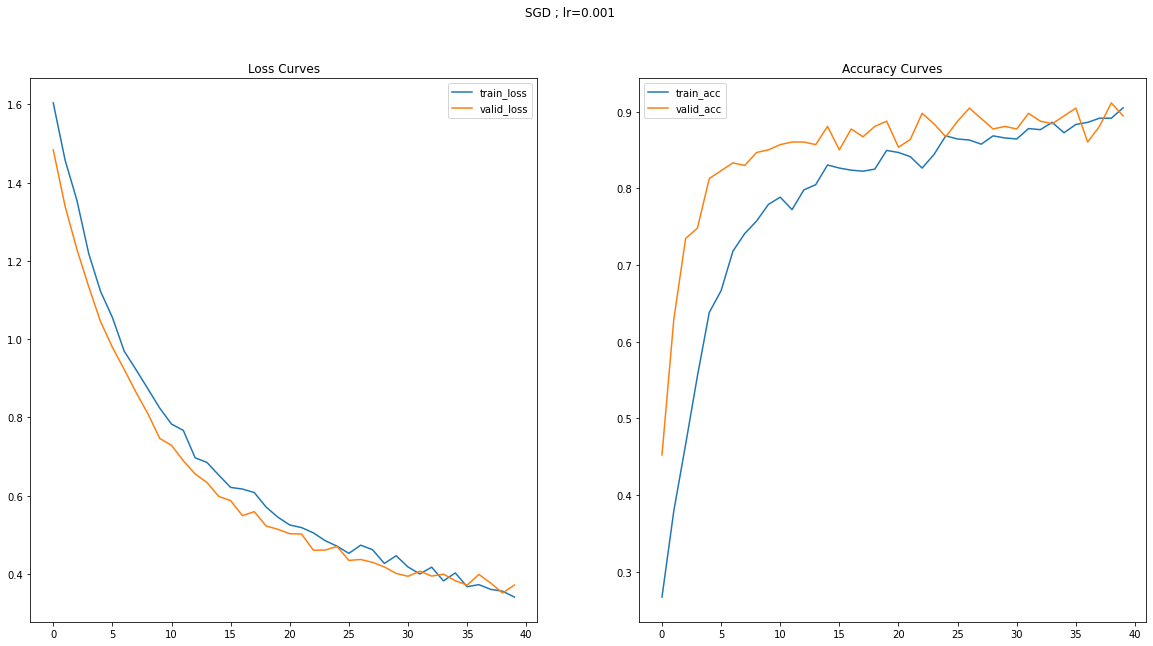

In [25]:
loss_acc_visuaize(history,optim='SGD ; lr=0.001',path='../')

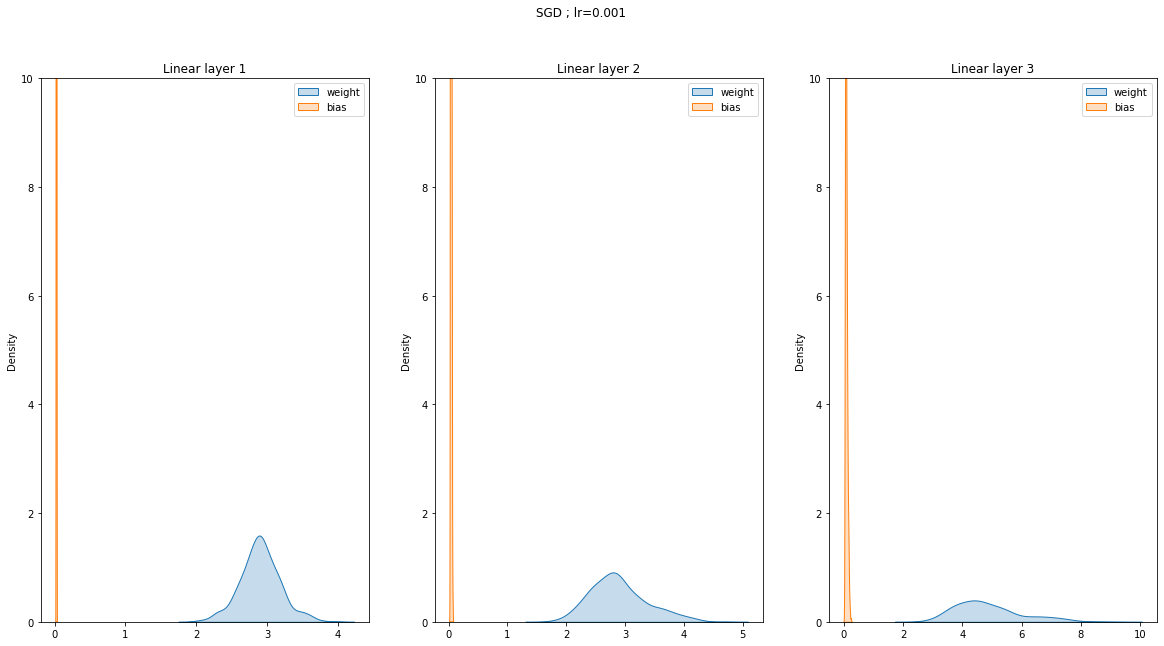

In [26]:
grad_visualize(history,optim='SGD ; lr=0.001',path='../')

In [27]:
model = base_model_build()
model.load_state_dict(torch.load("../vgg16-transfer-sgd-lr=0.001"))

training on gpu...


<All keys matched successfully>

tensor([[1.3919e-02, 1.3764e+02, 1.3369e-02, 1.8020e+00, 6.5187e+00]],
       device='cuda:0')


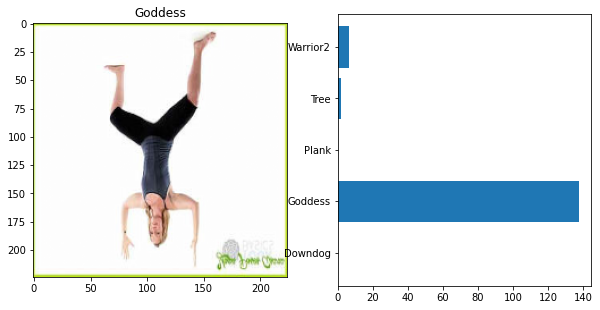

In [28]:
visual_predict(model=model)

In [29]:
sgd_lr001_dict = class_accuracies(model=model)

Accuracy for class Downdog :  0.9655172413793104
Accuracy for class Tree :  0.7966101694915254
Accuracy for class Plank :  0.9661016949152542
Accuracy for class Warrior2 :  0.864406779661017
Accuracy for class Goddess :  0.8983050847457628


In [30]:
# SGD with high learning rate

vgg16 = base_model_build()
optimizer_sgd = optim.SGD(vgg16.classifier.parameters(), lr=0.05)

model=vgg16
criterion=criterion
optimizer=optimizer_sgd
train_loader=train_loader
valid_loader=valid_loader
save_file_name='../vgg16-transfer-sgd-lr=0.05'
max_epochs_stop=5
n_epochs=40
print_every=1

"""Train a PyTorch Model

Params
--------
    model (PyTorch model): cnn to train
    criterion (PyTorch loss): objective to minimize
    optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
    train_loader (PyTorch dataloader): training dataloader to iterate through
    valid_loader (PyTorch dataloader): validation dataloader used for early stopping
    save_file_name (str ending in '.pt'): file path to save the model state dict
    max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
    n_epochs (int): maximum number of training epochs
    print_every (int): frequency of epochs to print training stats

Returns
--------
    model (PyTorch model): trained cnn with best weights
    history (DataFrame): history of train and validation loss and accuracy
"""

# Early stopping intialization
epochs_no_improve = 0
valid_loss_min = np.Inf

valid_max_acc = 0
history = []
bias_grads1 = []
weight_grads1 = []
bias_grads2 = []
weight_grads2 = []
bias_grads3 = []
weight_grads3 = []


# Number of epochs already trained (if using loaded in model weights)
try:
    print(f'Model has been trained for: {model.epochs} epochs.\n')
except:
    model.epochs = 0
    print(f'Starting Training from Scratch.\n')

overall_start = timer()

# Main loop
for epoch in range(n_epochs):

    # keep track of training and validation loss each epoch
    train_loss = 0.0
    valid_loss = 0.0

    train_acc = 0
    valid_acc = 0

    # Set to training
    model.train()
    start = timer()

    # Training loop
    for ii, (data, target) in enumerate(train_loader):
        # Tensors to gpu
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Clear gradients
        optimizer.zero_grad()
        # Predicted outputs are log probabilities
        output = model(data)

        # Loss and backpropagation of gradients
        loss = criterion(output, target)
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        weight_grads1.append(np.linalg.norm(model.classifier[0].weight.grad.cpu().numpy()))
        bias_grads1.append(np.linalg.norm(model.classifier[0].bias.grad.cpu().numpy()))
        weight_grads2.append(np.linalg.norm(model.classifier[3].weight.grad.cpu().numpy()))
        bias_grads2.append(np.linalg.norm(model.classifier[3].bias.grad.cpu().numpy()))
        weight_grads3.append(np.linalg.norm(model.classifier[6].weight.grad.cpu().numpy()))
        bias_grads3.append(np.linalg.norm(model.classifier[6].bias.grad.cpu().numpy()))



        # Track train loss by multiplying average loss by number of examples in batch
        train_loss += loss.item() * data.size(0)

        # Calculate accuracy by finding max log probability
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        # Need to convert correct tensor from int to float to average
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples in batch
        train_acc += accuracy.item() * data.size(0)

        # Track training progress
        print(
            f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
            end='\r')

    # After training loops ends, start validation
    else:
        model.epochs += 1

        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for data, target in valid_loader:
                # Tensors to gpu
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                # Forward pass
                output = model(data)

                # Validation loss
                loss = criterion(output, target)
                # Multiply average loss times the number of examples in batch
                valid_loss += loss.item() * data.size(0)

                # Calculate validation accuracy
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))
                # Multiply average accuracy times the number of examples
                valid_acc += accuracy.item() * data.size(0)

            # Calculate average losses
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)

            # Calculate average accuracy
            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(valid_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            # Print training and validation results
            if (epoch + 1) % print_every == 0:
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                )

            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                # Save model
                torch.save(model.state_dict(), save_file_name)
                # Track improvement
                epochs_no_improve = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                # Trigger early stopping
                if epochs_no_improve >= max_epochs_stop:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                    )
                    total_time = timer() - overall_start
                    print(
                        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                    )

                    # Load the best state dict
                    model.load_state_dict(torch.load(save_file_name))
                    # Attach the optimizer
                    model.optimizer = optimizer

                    # Format history
                    history = pd.DataFrame(
                        history,
                        columns=[
                            'train_loss', 'valid_loss', 'train_acc',
                            'valid_acc'
                        ])
                    break

# Attach the optimizer
model.optimizer = optimizer
# Record overall time and print out stats
total_time = timer() - overall_start
print(
    f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
)
print(
    f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
)
# Format history
history = pd.DataFrame(
    history,
    columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

training on gpu...
Starting Training from Scratch.

Epoch: 0	100.00% complete. 11.52 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 1.6171 	Validation Loss: 0.6281
		Training Accuracy: 55.69%	 Validation Accuracy: 82.65%
Epoch: 1	100.00% complete. 11.91 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.5076 	Validation Loss: 0.3650
		Training Accuracy: 83.06%	 Validation Accuracy: 88.44%
Epoch: 2	100.00% complete. 11.43 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.2924 	Validation Loss: 0.3591
		Training Accuracy: 88.75%	 Validation Accuracy: 89.46%
Epoch: 3	100.00% complete. 11.56 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.2679 	Validation Loss: 0.2172
		Training Accuracy: 90.79%	 Validation Accuracy: 93.54%
Epoch: 4	100.00% complete. 11.50 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.1241 	Validation Loss: 0.2264
		Training Accuracy: 96.48%	 Validation Accuracy: 93.88%
Epoch: 5	100.00% complete. 11.64 seconds elapsed in epoch.
Epoch: 5 	Training Loss:

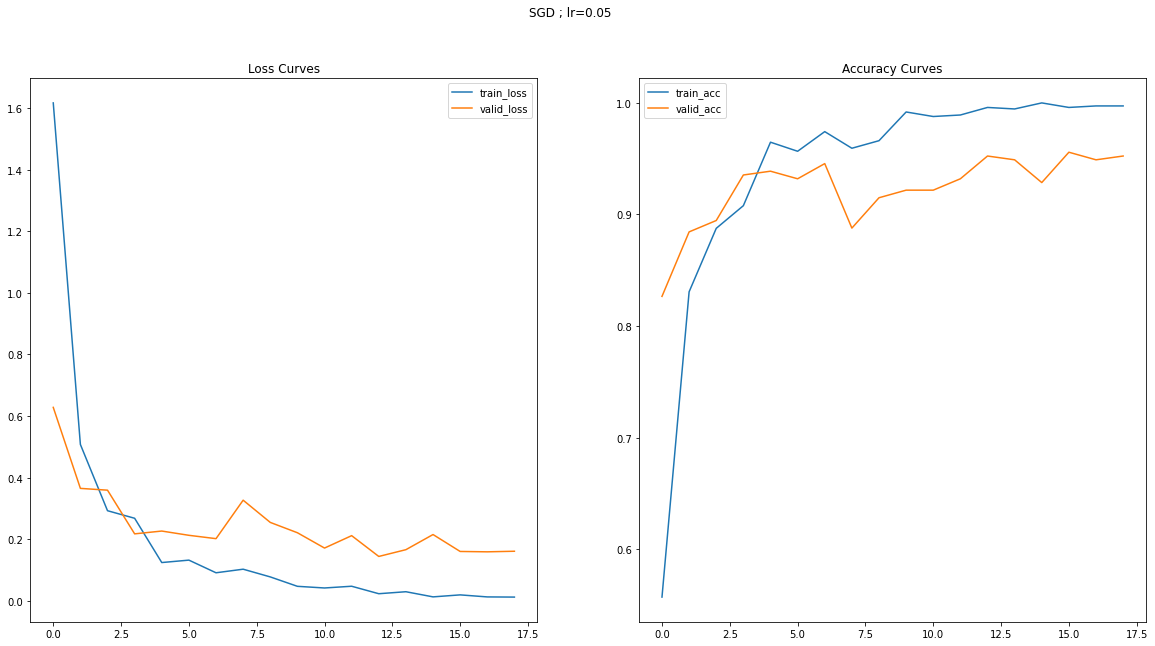

In [31]:
loss_acc_visuaize(history,optim='SGD ; lr=0.05',path='../lr=0.05')

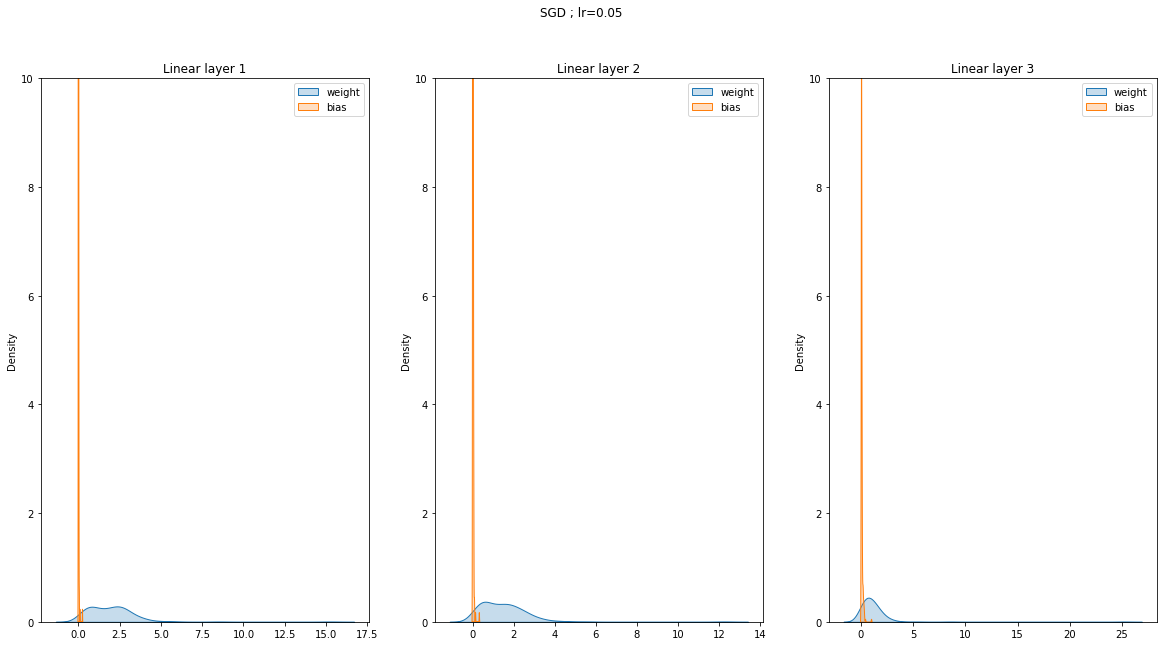

In [32]:
grad_visualize(history,optim='SGD ; lr=0.05',path='../lr=0.05')

In [33]:
model = base_model_build()
model.load_state_dict(torch.load("../vgg16-transfer-sgd-lr=0.05"))

training on gpu...


<All keys matched successfully>

tensor([[2.0393e+02, 8.9819e-02, 1.4523e+02, 1.7701e-02, 6.5073e-02]],
       device='cuda:0')


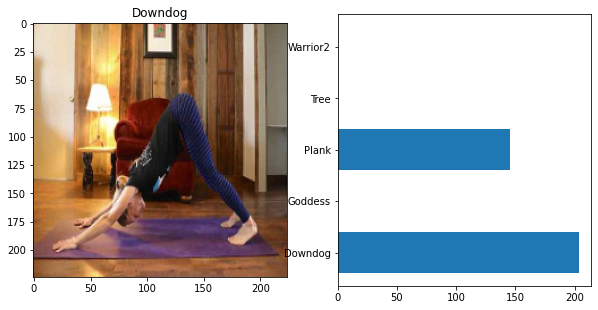

In [34]:
visual_predict(model=model)

In [35]:
sgd_lr05_dict = class_accuracies(model=model)

Accuracy for class Downdog :  0.9655172413793104
Accuracy for class Tree :  0.9152542372881356
Accuracy for class Plank :  0.9491525423728814
Accuracy for class Warrior2 :  0.8813559322033898
Accuracy for class Goddess :  0.9491525423728814


### **Adam**

Adam can be looked at as a combination of RMSprop and Stochastic Gradient Descent with momentum. It uses the squared gradients to scale the learning rate like RMSprop and it takes advantage of momentum by using moving average of the gradient instead of gradient itself like SGD with momentum. 

In [36]:
vgg16 = base_model_build()
optimizer_adam = optim.Adam(vgg16.classifier.parameters(), lr=0.001)

model=vgg16
criterion=criterion
optimizer=optimizer_adam
train_loader=train_loader
valid_loader=valid_loader
save_file_name='../vgg16-transfer-adam-lr=0.001'
max_epochs_stop=5
n_epochs=40
print_every=1

"""Train a PyTorch Model

Params
--------
    model (PyTorch model): cnn to train
    criterion (PyTorch loss): objective to minimize
    optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
    train_loader (PyTorch dataloader): training dataloader to iterate through
    valid_loader (PyTorch dataloader): validation dataloader used for early stopping
    save_file_name (str ending in '.pt'): file path to save the model state dict
    max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
    n_epochs (int): maximum number of training epochs
    print_every (int): frequency of epochs to print training stats

Returns
--------
    model (PyTorch model): trained cnn with best weights
    history (DataFrame): history of train and validation loss and accuracy
"""

# Early stopping intialization
epochs_no_improve = 0
valid_loss_min = np.Inf

valid_max_acc = 0
history = []
bias_grads1 = []
weight_grads1 = []
bias_grads2 = []
weight_grads2 = []
bias_grads3 = []
weight_grads3 = []


# Number of epochs already trained (if using loaded in model weights)
try:
    print(f'Model has been trained for: {model.epochs} epochs.\n')
except:
    model.epochs = 0
    print(f'Starting Training from Scratch.\n')

overall_start = timer()

# Main loop
for epoch in range(n_epochs):

    # keep track of training and validation loss each epoch
    train_loss = 0.0
    valid_loss = 0.0

    train_acc = 0
    valid_acc = 0

    # Set to training
    model.train()
    start = timer()

    # Training loop
    for ii, (data, target) in enumerate(train_loader):
        # Tensors to gpu
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Clear gradients
        optimizer.zero_grad()
        # Predicted outputs are log probabilities
        output = model(data)

        # Loss and backpropagation of gradients
        loss = criterion(output, target)
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        weight_grads1.append(np.linalg.norm(model.classifier[0].weight.grad.cpu().numpy()))
        bias_grads1.append(np.linalg.norm(model.classifier[0].bias.grad.cpu().numpy()))
        weight_grads2.append(np.linalg.norm(model.classifier[3].weight.grad.cpu().numpy()))
        bias_grads2.append(np.linalg.norm(model.classifier[3].bias.grad.cpu().numpy()))
        weight_grads3.append(np.linalg.norm(model.classifier[6].weight.grad.cpu().numpy()))
        bias_grads3.append(np.linalg.norm(model.classifier[6].bias.grad.cpu().numpy()))



        # Track train loss by multiplying average loss by number of examples in batch
        train_loss += loss.item() * data.size(0)

        # Calculate accuracy by finding max log probability
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        # Need to convert correct tensor from int to float to average
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples in batch
        train_acc += accuracy.item() * data.size(0)

        # Track training progress
        print(
            f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
            end='\r')

    # After training loops ends, start validation
    else:
        model.epochs += 1

        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for data, target in valid_loader:
                # Tensors to gpu
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                # Forward pass
                output = model(data)

                # Validation loss
                loss = criterion(output, target)
                # Multiply average loss times the number of examples in batch
                valid_loss += loss.item() * data.size(0)

                # Calculate validation accuracy
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))
                # Multiply average accuracy times the number of examples
                valid_acc += accuracy.item() * data.size(0)

            # Calculate average losses
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)

            # Calculate average accuracy
            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(valid_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            # Print training and validation results
            if (epoch + 1) % print_every == 0:
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                )

            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                # Save model
                torch.save(model.state_dict(), save_file_name)
                # Track improvement
                epochs_no_improve = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                # Trigger early stopping
                if epochs_no_improve >= max_epochs_stop:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                    )
                    total_time = timer() - overall_start
                    print(
                        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                    )

                    # Load the best state dict
                    model.load_state_dict(torch.load(save_file_name))
                    # Attach the optimizer
                    model.optimizer = optimizer

                    # Format history
                    history = pd.DataFrame(
                        history,
                        columns=[
                            'train_loss', 'valid_loss', 'train_acc',
                            'valid_acc'
                        ])
                    break

# Attach the optimizer
model.optimizer = optimizer
# Record overall time and print out stats
total_time = timer() - overall_start
print(
    f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
)
print(
    f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
)
# Format history
history = pd.DataFrame(
    history,
    columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

training on gpu...
Starting Training from Scratch.

Epoch: 0	100.00% complete. 12.02 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 1.4478 	Validation Loss: 0.7190
		Training Accuracy: 53.39%	 Validation Accuracy: 75.51%
Epoch: 1	100.00% complete. 11.83 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.5823 	Validation Loss: 0.2762
		Training Accuracy: 82.79%	 Validation Accuracy: 91.16%
Epoch: 2	100.00% complete. 12.15 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.2947 	Validation Loss: 0.3018
		Training Accuracy: 90.65%	 Validation Accuracy: 91.50%
Epoch: 3	100.00% complete. 11.60 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.1861 	Validation Loss: 0.1811
		Training Accuracy: 95.39%	 Validation Accuracy: 93.20%
Epoch: 4	100.00% complete. 11.77 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.2232 	Validation Loss: 0.2550
		Training Accuracy: 93.90%	 Validation Accuracy: 93.88%
Epoch: 5	100.00% complete. 11.64 seconds elapsed in epoch.
Epoch: 5 	Training Loss:

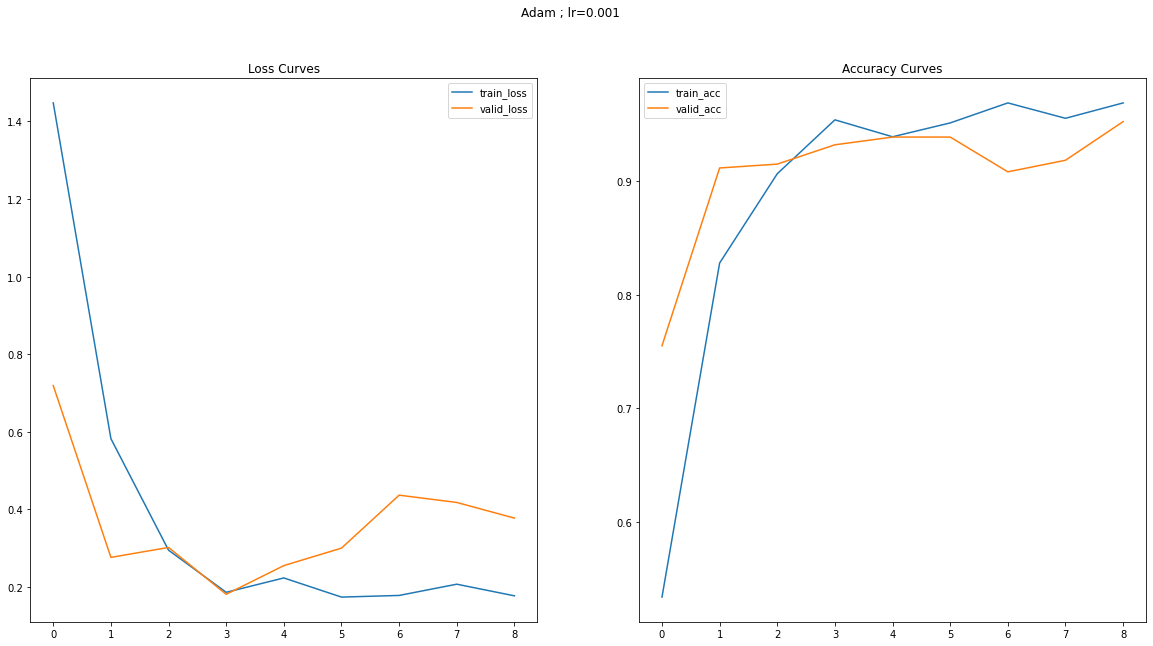

In [37]:
loss_acc_visuaize(history,optim='Adam ; lr=0.001',path='../lr=0.001')

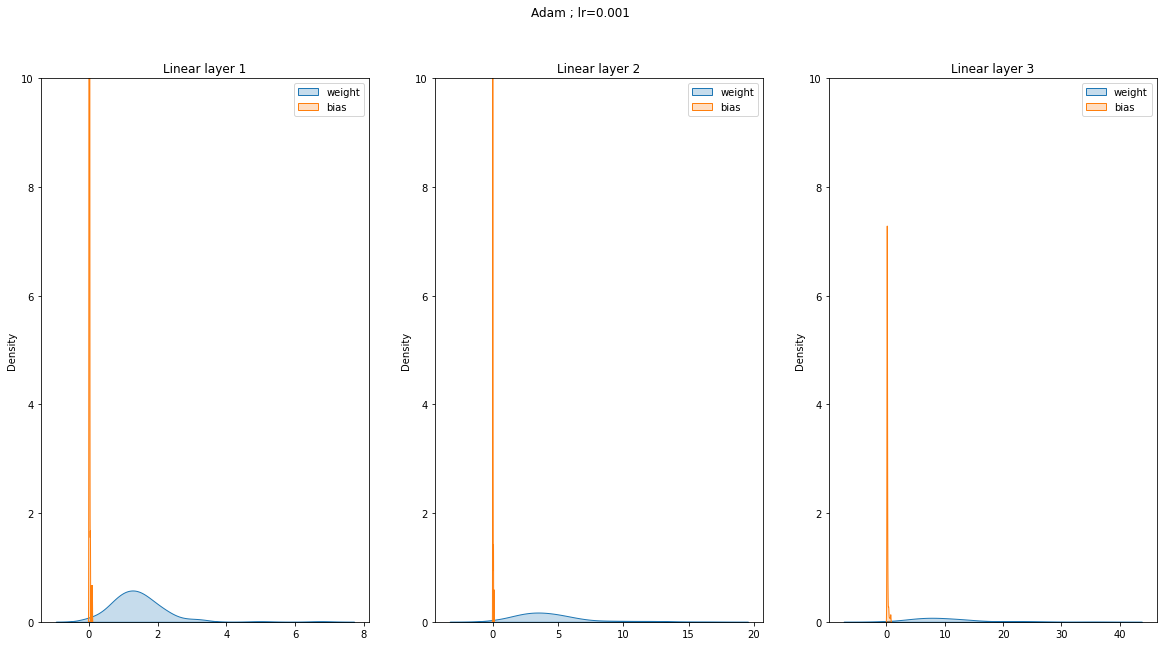

In [38]:
grad_visualize(history,optim='Adam ; lr=0.001',path='../lr=0.001')

In [39]:
model = base_model_build()
model.load_state_dict(torch.load("../vgg16-transfer-adam-lr=0.001"))

training on gpu...


<All keys matched successfully>

tensor([[2.6800e+00, 2.1150e-03, 1.7741e+03, 9.5727e-03, 1.2049e-03]],
       device='cuda:0')


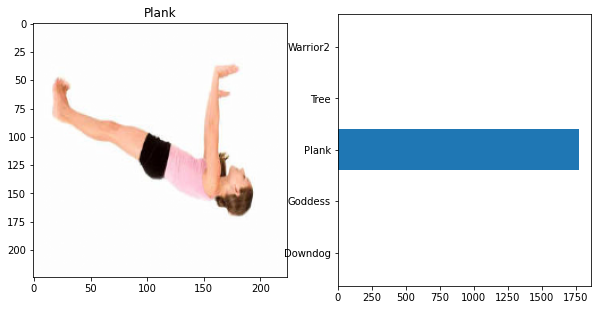

In [40]:
visual_predict(model)

In [41]:
adam_lr001_dict = class_accuracies(model=model)

Accuracy for class Downdog :  0.9655172413793104
Accuracy for class Tree :  0.8983050847457628
Accuracy for class Plank :  0.9152542372881356
Accuracy for class Warrior2 :  0.8135593220338984
Accuracy for class Goddess :  0.9830508474576272


In [42]:
# Adam with high learning rate

vgg16 = base_model_build()
optimizer_adam = optim.Adam(vgg16.classifier.parameters(), lr=0.05)

model=vgg16
criterion=criterion
optimizer=optimizer_adam
train_loader=train_loader
valid_loader=valid_loader
save_file_name='../vgg16-transfer-sgd-lr=0.05'
max_epochs_stop=5
n_epochs=10
print_every=1

"""Train a PyTorch Model

Params
--------
    model (PyTorch model): cnn to train
    criterion (PyTorch loss): objective to minimize
    optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
    train_loader (PyTorch dataloader): training dataloader to iterate through
    valid_loader (PyTorch dataloader): validation dataloader used for early stopping
    save_file_name (str ending in '.pt'): file path to save the model state dict
    max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
    n_epochs (int): maximum number of training epochs
    print_every (int): frequency of epochs to print training stats

Returns
--------
    model (PyTorch model): trained cnn with best weights
    history (DataFrame): history of train and validation loss and accuracy
"""

# Early stopping intialization
epochs_no_improve = 0
valid_loss_min = np.Inf

valid_max_acc = 0
history = []
bias_grads1 = []
weight_grads1 = []
bias_grads2 = []
weight_grads2 = []
bias_grads3 = []
weight_grads3 = []


# Number of epochs already trained (if using loaded in model weights)
try:
    print(f'Model has been trained for: {model.epochs} epochs.\n')
except:
    model.epochs = 0
    print(f'Starting Training from Scratch.\n')

overall_start = timer()

# Main loop
for epoch in range(n_epochs):

    # keep track of training and validation loss each epoch
    train_loss = 0.0
    valid_loss = 0.0

    train_acc = 0
    valid_acc = 0

    # Set to training
    model.train()
    start = timer()

    # Training loop
    for ii, (data, target) in enumerate(train_loader):
        # Tensors to gpu
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Clear gradients
        optimizer.zero_grad()
        # Predicted outputs are log probabilities
        output = model(data)

        # Loss and backpropagation of gradients
        loss = criterion(output, target)
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        weight_grads1.append(np.linalg.norm(model.classifier[0].weight.grad.cpu().numpy()))
        bias_grads1.append(np.linalg.norm(model.classifier[0].bias.grad.cpu().numpy()))
        weight_grads2.append(np.linalg.norm(model.classifier[3].weight.grad.cpu().numpy()))
        bias_grads2.append(np.linalg.norm(model.classifier[3].bias.grad.cpu().numpy()))
        weight_grads3.append(np.linalg.norm(model.classifier[6].weight.grad.cpu().numpy()))
        bias_grads3.append(np.linalg.norm(model.classifier[6].bias.grad.cpu().numpy()))



        # Track train loss by multiplying average loss by number of examples in batch
        train_loss += loss.item() * data.size(0)

        # Calculate accuracy by finding max log probability
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        # Need to convert correct tensor from int to float to average
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples in batch
        train_acc += accuracy.item() * data.size(0)

        # Track training progress
        print(
            f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
            end='\r')

    # After training loops ends, start validation
    else:
        model.epochs += 1

        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for data, target in valid_loader:
                # Tensors to gpu
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                # Forward pass
                output = model(data)

                # Validation loss
                loss = criterion(output, target)
                # Multiply average loss times the number of examples in batch
                valid_loss += loss.item() * data.size(0)

                # Calculate validation accuracy
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))
                # Multiply average accuracy times the number of examples
                valid_acc += accuracy.item() * data.size(0)

            # Calculate average losses
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)

            # Calculate average accuracy
            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(valid_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            # Print training and validation results
            if (epoch + 1) % print_every == 0:
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                )

            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                # Save model
                torch.save(model.state_dict(), save_file_name)
                # Track improvement
                epochs_no_improve = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                # Trigger early stopping
                if epochs_no_improve >= max_epochs_stop:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                    )
                    total_time = timer() - overall_start
                    print(
                        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                    )

                    # Load the best state dict
                    model.load_state_dict(torch.load(save_file_name))
                    # Attach the optimizer
                    model.optimizer = optimizer

                    # Format history
                    history = pd.DataFrame(
                        history,
                        columns=[
                            'train_loss', 'valid_loss', 'train_acc',
                            'valid_acc'
                        ])
                    break

# Attach the optimizer
model.optimizer = optimizer
# Record overall time and print out stats
total_time = timer() - overall_start
print(
    f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
)
print(
    f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
)
# Format history
history = pd.DataFrame(
    history,
    columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

training on gpu...
Starting Training from Scratch.

Epoch: 0	100.00% complete. 12.16 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 30724.8231 	Validation Loss: 275.3839
		Training Accuracy: 28.05%	 Validation Accuracy: 66.33%
Epoch: 1	100.00% complete. 11.68 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 1591.5428 	Validation Loss: 375.5433
		Training Accuracy: 56.23%	 Validation Accuracy: 68.37%
Epoch: 2	100.00% complete. 11.97 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 1166.3168 	Validation Loss: 234.4611
		Training Accuracy: 62.06%	 Validation Accuracy: 84.69%
Epoch: 3	100.00% complete. 11.76 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 752.3123 	Validation Loss: 361.2290
		Training Accuracy: 73.58%	 Validation Accuracy: 85.03%
Epoch: 4	100.00% complete. 11.90 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 788.8295 	Validation Loss: 226.7193
		Training Accuracy: 73.04%	 Validation Accuracy: 83.33%
Epoch: 5	100.00% complete. 11.76 seconds elapsed in epoch.


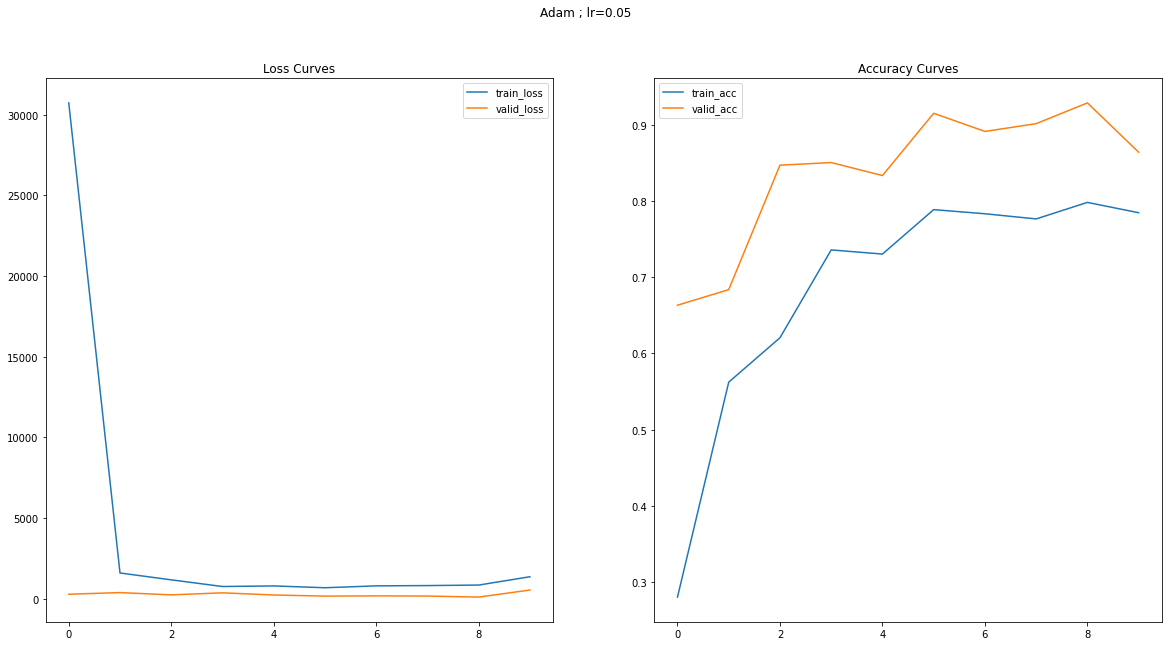

In [43]:
loss_acc_visuaize(history,optim='Adam ; lr=0.05',path='../lr=0.05')

### **RMSProp**

RMSprop is a gradient-based optimization technique used in training neural networks. It was proposed by the father of back-propagation, Geoffrey Hinton. Gradients of very complex functions like neural networks have a tendency to either vanish or explode as the data propagates through the function (refer to vanishing gradients problem). Rmsprop was developed as a stochastic technique for mini-batch learning.

RMSprop deals with the above issue by using a moving average of squared gradients to normalize the gradient. This normalization balances the step size (momentum), decreasing the step for large gradients to avoid exploding and increasing the step for small gradients to avoid vanishing.
Simply put, RMSprop uses an adaptive learning rate instead of treating the learning rate as a hyperparameter. This means that the learning rate changes over time.

In [44]:
vgg16 = base_model_build()
optimizer_adam = optim.RMSprop(vgg16.classifier.parameters(), lr=0.001)

model=vgg16
criterion=criterion
optimizer=optimizer_adam
train_loader=train_loader
valid_loader=valid_loader
save_file_name='../vgg16-transfer-rmsprop-lr=0.001'
max_epochs_stop=5
n_epochs=40
print_every=1

"""Train a PyTorch Model

Params
--------
    model (PyTorch model): cnn to train
    criterion (PyTorch loss): objective to minimize
    optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
    train_loader (PyTorch dataloader): training dataloader to iterate through
    valid_loader (PyTorch dataloader): validation dataloader used for early stopping
    save_file_name (str ending in '.pt'): file path to save the model state dict
    max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
    n_epochs (int): maximum number of training epochs
    print_every (int): frequency of epochs to print training stats

Returns
--------
    model (PyTorch model): trained cnn with best weights
    history (DataFrame): history of train and validation loss and accuracy
"""

# Early stopping intialization
epochs_no_improve = 0
valid_loss_min = np.Inf

valid_max_acc = 0
history = []
bias_grads1 = []
weight_grads1 = []
bias_grads2 = []
weight_grads2 = []
bias_grads3 = []
weight_grads3 = []


# Number of epochs already trained (if using loaded in model weights)
try:
    print(f'Model has been trained for: {model.epochs} epochs.\n')
except:
    model.epochs = 0
    print(f'Starting Training from Scratch.\n')

overall_start = timer()

# Main loop
for epoch in range(n_epochs):

    # keep track of training and validation loss each epoch
    train_loss = 0.0
    valid_loss = 0.0

    train_acc = 0
    valid_acc = 0

    # Set to training
    model.train()
    start = timer()

    # Training loop
    for ii, (data, target) in enumerate(train_loader):
        # Tensors to gpu
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Clear gradients
        optimizer.zero_grad()
        # Predicted outputs are log probabilities
        output = model(data)

        # Loss and backpropagation of gradients
        loss = criterion(output, target)
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        weight_grads1.append(np.linalg.norm(model.classifier[0].weight.grad.cpu().numpy()))
        bias_grads1.append(np.linalg.norm(model.classifier[0].bias.grad.cpu().numpy()))
        weight_grads2.append(np.linalg.norm(model.classifier[3].weight.grad.cpu().numpy()))
        bias_grads2.append(np.linalg.norm(model.classifier[3].bias.grad.cpu().numpy()))
        weight_grads3.append(np.linalg.norm(model.classifier[6].weight.grad.cpu().numpy()))
        bias_grads3.append(np.linalg.norm(model.classifier[6].bias.grad.cpu().numpy()))



        # Track train loss by multiplying average loss by number of examples in batch
        train_loss += loss.item() * data.size(0)

        # Calculate accuracy by finding max log probability
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        # Need to convert correct tensor from int to float to average
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples in batch
        train_acc += accuracy.item() * data.size(0)

        # Track training progress
        print(
            f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
            end='\r')

    # After training loops ends, start validation
    else:
        model.epochs += 1

        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for data, target in valid_loader:
                # Tensors to gpu
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                # Forward pass
                output = model(data)

                # Validation loss
                loss = criterion(output, target)
                # Multiply average loss times the number of examples in batch
                valid_loss += loss.item() * data.size(0)

                # Calculate validation accuracy
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))
                # Multiply average accuracy times the number of examples
                valid_acc += accuracy.item() * data.size(0)

            # Calculate average losses
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)

            # Calculate average accuracy
            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(valid_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            # Print training and validation results
            if (epoch + 1) % print_every == 0:
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                )

            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                # Save model
                torch.save(model.state_dict(), save_file_name)
                # Track improvement
                epochs_no_improve = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                # Trigger early stopping
                if epochs_no_improve >= max_epochs_stop:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                    )
                    total_time = timer() - overall_start
                    print(
                        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                    )

                    # Load the best state dict
                    model.load_state_dict(torch.load(save_file_name))
                    # Attach the optimizer
                    model.optimizer = optimizer

                    # Format history
                    history = pd.DataFrame(
                        history,
                        columns=[
                            'train_loss', 'valid_loss', 'train_acc',
                            'valid_acc'
                        ])
                    break

# Attach the optimizer
model.optimizer = optimizer
# Record overall time and print out stats
total_time = timer() - overall_start
print(
    f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
)
print(
    f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
)
# Format history
history = pd.DataFrame(
    history,
    columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

training on gpu...
Starting Training from Scratch.

Epoch: 0	100.00% complete. 11.66 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 238.8787 	Validation Loss: 1.1746
		Training Accuracy: 39.70%	 Validation Accuracy: 68.37%
Epoch: 1	100.00% complete. 12.02 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 1.1765 	Validation Loss: 0.2891
		Training Accuracy: 78.59%	 Validation Accuracy: 91.16%
Epoch: 2	100.00% complete. 11.85 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.6130 	Validation Loss: 0.5267
		Training Accuracy: 85.64%	 Validation Accuracy: 82.99%
Epoch: 3	100.00% complete. 12.12 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.3510 	Validation Loss: 0.1956
		Training Accuracy: 89.57%	 Validation Accuracy: 93.54%
Epoch: 4	100.00% complete. 11.70 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.2195 	Validation Loss: 0.2098
		Training Accuracy: 94.72%	 Validation Accuracy: 93.54%
Epoch: 5	100.00% complete. 11.72 seconds elapsed in epoch.
Epoch: 5 	Training Los

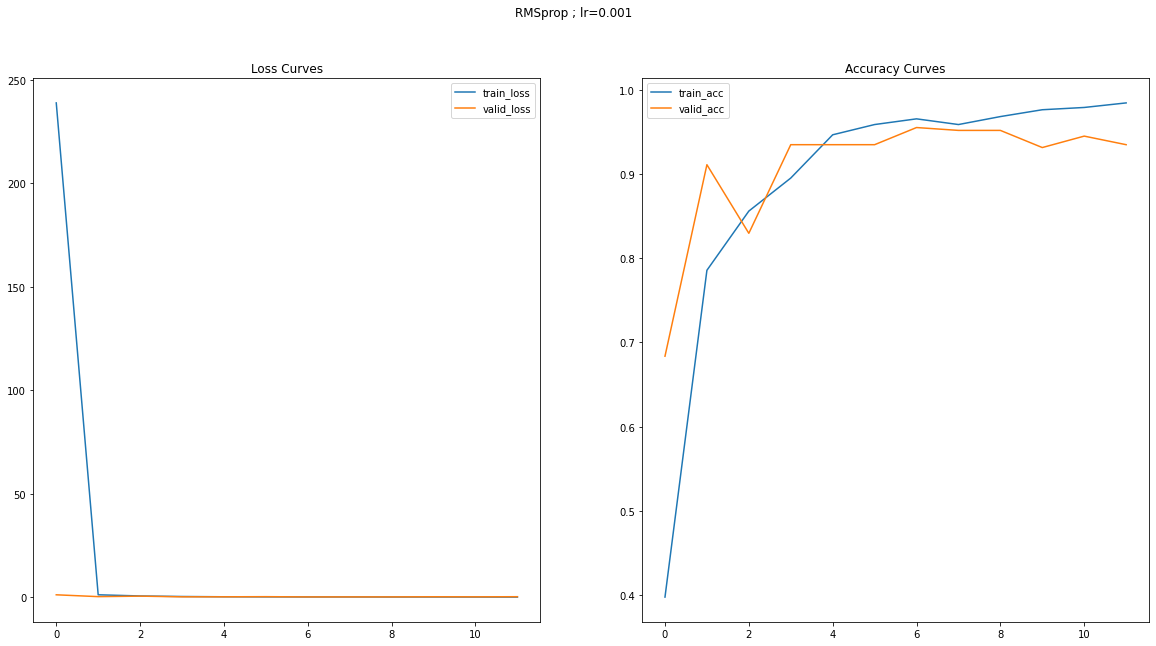

In [45]:
loss_acc_visuaize(history, optim='RMSprop ; lr=0.001',path='../lr=0.001')

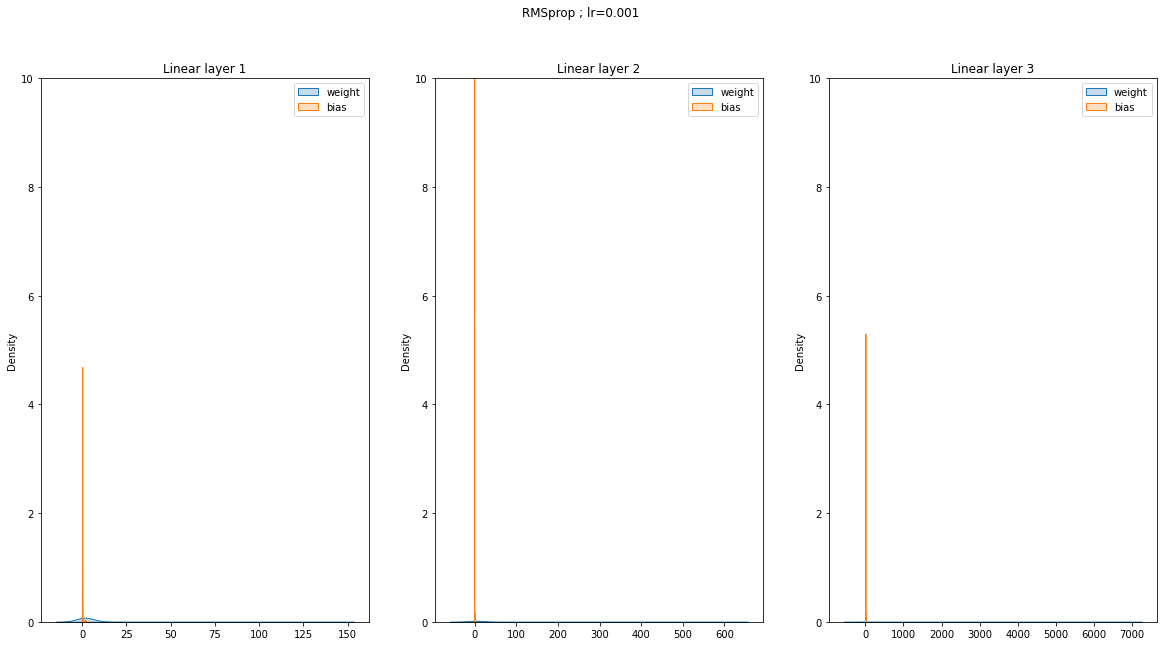

In [46]:
grad_visualize(history, optim='RMSprop ; lr=0.001',path='../lr=0.001')

In [47]:
model = base_model_build()
model.load_state_dict(torch.load("../vgg16-transfer-rmsprop-lr=0.001"))

training on gpu...


<All keys matched successfully>

tensor([[1.0012e-02, 2.1587e+02, 8.0394e-03, 3.0652e-02, 1.7070e+04]],
       device='cuda:0')


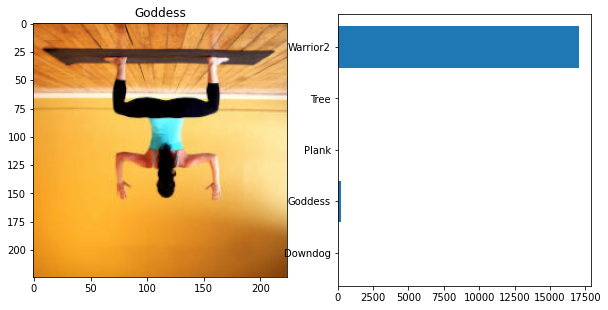

In [48]:
visual_predict(model)

In [49]:
rmsprop_lr001_dict=class_accuracies(model)

Accuracy for class Downdog :  0.9655172413793104
Accuracy for class Tree :  0.8983050847457628
Accuracy for class Plank :  0.9661016949152542
Accuracy for class Warrior2 :  0.9152542372881356
Accuracy for class Goddess :  0.9661016949152542


In [50]:
# RMSprop with high learning rate

vgg16 = base_model_build()
optimizer_adam = optim.RMSprop(vgg16.classifier.parameters(), lr=0.05)

model=vgg16
criterion=criterion
optimizer=optimizer_adam
train_loader=train_loader
valid_loader=valid_loader
save_file_name='../vgg16-transfer-sgd-1'
max_epochs_stop=5
n_epochs=40
print_every=1

"""Train a PyTorch Model

Params
--------
    model (PyTorch model): cnn to train
    criterion (PyTorch loss): objective to minimize
    optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
    train_loader (PyTorch dataloader): training dataloader to iterate through
    valid_loader (PyTorch dataloader): validation dataloader used for early stopping
    save_file_name (str ending in '.pt'): file path to save the model state dict
    max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
    n_epochs (int): maximum number of training epochs
    print_every (int): frequency of epochs to print training stats

Returns
--------
    model (PyTorch model): trained cnn with best weights
    history (DataFrame): history of train and validation loss and accuracy
"""

# Early stopping intialization
epochs_no_improve = 0
valid_loss_min = np.Inf

valid_max_acc = 0
history = []
bias_grads1 = []
weight_grads1 = []
bias_grads2 = []
weight_grads2 = []
bias_grads3 = []
weight_grads3 = []


# Number of epochs already trained (if using loaded in model weights)
try:
    print(f'Model has been trained for: {model.epochs} epochs.\n')
except:
    model.epochs = 0
    print(f'Starting Training from Scratch.\n')

overall_start = timer()

# Main loop
for epoch in range(n_epochs):

    # keep track of training and validation loss each epoch
    train_loss = 0.0
    valid_loss = 0.0

    train_acc = 0
    valid_acc = 0

    # Set to training
    model.train()
    start = timer()

    # Training loop
    for ii, (data, target) in enumerate(train_loader):
        # Tensors to gpu
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Clear gradients
        optimizer.zero_grad()
        # Predicted outputs are log probabilities
        output = model(data)

        # Loss and backpropagation of gradients
        loss = criterion(output, target)
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        weight_grads1.append(np.linalg.norm(model.classifier[0].weight.grad.cpu().numpy()))
        bias_grads1.append(np.linalg.norm(model.classifier[0].bias.grad.cpu().numpy()))
        weight_grads2.append(np.linalg.norm(model.classifier[3].weight.grad.cpu().numpy()))
        bias_grads2.append(np.linalg.norm(model.classifier[3].bias.grad.cpu().numpy()))
        weight_grads3.append(np.linalg.norm(model.classifier[6].weight.grad.cpu().numpy()))
        bias_grads3.append(np.linalg.norm(model.classifier[6].bias.grad.cpu().numpy()))



        # Track train loss by multiplying average loss by number of examples in batch
        train_loss += loss.item() * data.size(0)

        # Calculate accuracy by finding max log probability
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        # Need to convert correct tensor from int to float to average
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples in batch
        train_acc += accuracy.item() * data.size(0)

        # Track training progress
        print(
            f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
            end='\r')

    # After training loops ends, start validation
    else:
        model.epochs += 1

        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for data, target in valid_loader:
                # Tensors to gpu
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                # Forward pass
                output = model(data)

                # Validation loss
                loss = criterion(output, target)
                # Multiply average loss times the number of examples in batch
                valid_loss += loss.item() * data.size(0)

                # Calculate validation accuracy
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))
                # Multiply average accuracy times the number of examples
                valid_acc += accuracy.item() * data.size(0)

            # Calculate average losses
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)

            # Calculate average accuracy
            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(valid_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            # Print training and validation results
            if (epoch + 1) % print_every == 0:
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                )

            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                # Save model
                torch.save(model.state_dict(), save_file_name)
                # Track improvement
                epochs_no_improve = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                # Trigger early stopping
                if epochs_no_improve >= max_epochs_stop:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                    )
                    total_time = timer() - overall_start
                    print(
                        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                    )

                    # Load the best state dict
                    model.load_state_dict(torch.load(save_file_name))
                    # Attach the optimizer
                    model.optimizer = optimizer

                    # Format history
                    history = pd.DataFrame(
                        history,
                        columns=[
                            'train_loss', 'valid_loss', 'train_acc',
                            'valid_acc'
                        ])
                    break

# Attach the optimizer
model.optimizer = optimizer
# Record overall time and print out stats
total_time = timer() - overall_start
print(
    f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
)
print(
    f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
)
# Format history
history = pd.DataFrame(
    history,
    columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

training on gpu...
Starting Training from Scratch.

Epoch: 0	100.00% complete. 11.74 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 16063856.0715 	Validation Loss: 459131.5861
		Training Accuracy: 29.13%	 Validation Accuracy: 42.86%
Epoch: 1	100.00% complete. 11.70 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 121268.1878 	Validation Loss: 4745.7647
		Training Accuracy: 65.04%	 Validation Accuracy: 90.48%
Epoch: 2	100.00% complete. 11.86 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 29365.7978 	Validation Loss: 9361.5736
		Training Accuracy: 81.84%	 Validation Accuracy: 87.07%
Epoch: 3	100.00% complete. 11.58 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 17006.6740 	Validation Loss: 3239.3867
		Training Accuracy: 84.15%	 Validation Accuracy: 88.10%
Epoch: 4	100.00% complete. 11.78 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 11000.7274 	Validation Loss: 3385.5069
		Training Accuracy: 84.82%	 Validation Accuracy: 90.82%
Epoch: 5	100.00% complete. 11.60 seconds e

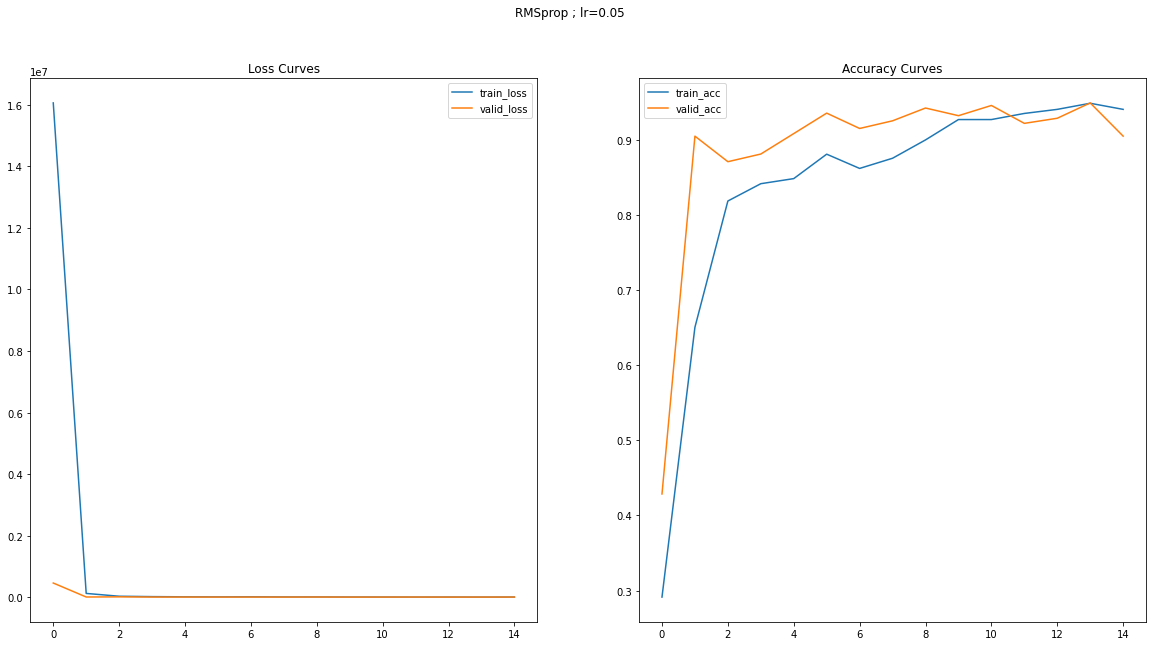

In [51]:
loss_acc_visuaize(history, optim='RMSprop ; lr=0.05',path='../lr=0.05')

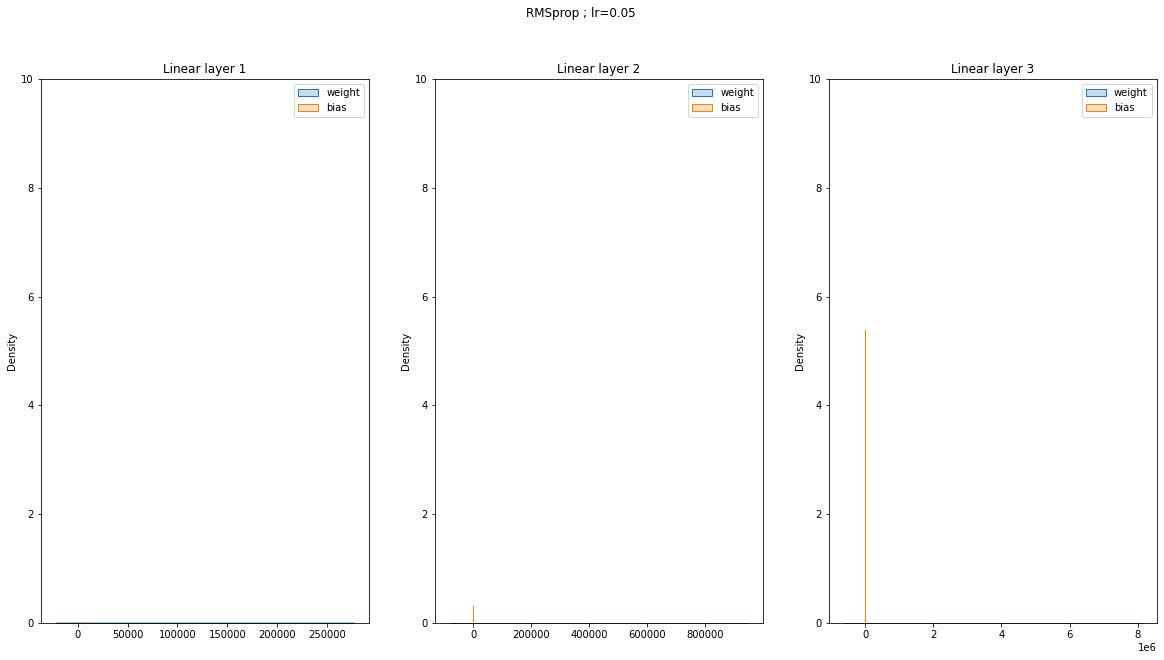

In [52]:
grad_visualize(history, optim='RMSprop ; lr=0.05',path='../lr=0.05')

In [53]:
model = base_model_build()
model.load_state_dict(torch.load("../vgg16-transfer-sgd-1"))

training on gpu...


<All keys matched successfully>

tensor([[0., inf, 0., inf, inf]], device='cuda:0')


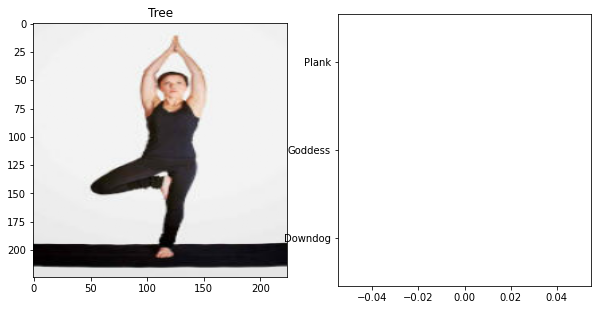

In [54]:
visual_predict(model)

In [55]:
_=class_accuracies(model)

Accuracy for class Downdog :  1.0
Accuracy for class Tree :  0.03389830508474576
Accuracy for class Plank :  0.0
Accuracy for class Warrior2 :  0.0
Accuracy for class Goddess :  0.9830508474576272


## **Adagrad**

Adaptive Gradient Algorithm (Adagrad) is an algorithm for gradient-based optimization. The learning rate is adapted component-wise to the parameters by incorporating knowledge of past observations.  It performs larger updates (e.g. high learning rates) for those parameters that are related to infrequent features and smaller updates (i.e. low learning rates) for frequent one. It performs smaller updates As a result, it is well-suited when dealing with sparse data (NLP or image recognition) Each parameter has its own learning rate that improves performance on problems with sparse gradients.

In [56]:
vgg16 = base_model_build()
optimizer_adam = optim.Adagrad(vgg16.classifier.parameters(), lr=0.001)

model=vgg16
criterion=criterion
optimizer=optimizer_adam
train_loader=train_loader
valid_loader=valid_loader
save_file_name='../vgg16-transfer-adagrad-lr=0.001'
max_epochs_stop=5
n_epochs=40
print_every=1

"""Train a PyTorch Model

Params
--------
    model (PyTorch model): cnn to train
    criterion (PyTorch loss): objective to minimize
    optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
    train_loader (PyTorch dataloader): training dataloader to iterate through
    valid_loader (PyTorch dataloader): validation dataloader used for early stopping
    save_file_name (str ending in '.pt'): file path to save the model state dict
    max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
    n_epochs (int): maximum number of training epochs
    print_every (int): frequency of epochs to print training stats

Returns
--------
    model (PyTorch model): trained cnn with best weights
    history (DataFrame): history of train and validation loss and accuracy
"""

# Early stopping intialization
epochs_no_improve = 0
valid_loss_min = np.Inf

valid_max_acc = 0
history = []
bias_grads1 = []
weight_grads1 = []
bias_grads2 = []
weight_grads2 = []
bias_grads3 = []
weight_grads3 = []


# Number of epochs already trained (if using loaded in model weights)
try:
    print(f'Model has been trained for: {model.epochs} epochs.\n')
except:
    model.epochs = 0
    print(f'Starting Training from Scratch.\n')

overall_start = timer()

# Main loop
for epoch in range(n_epochs):

    # keep track of training and validation loss each epoch
    train_loss = 0.0
    valid_loss = 0.0

    train_acc = 0
    valid_acc = 0

    # Set to training
    model.train()
    start = timer()

    # Training loop
    for ii, (data, target) in enumerate(train_loader):
        # Tensors to gpu
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Clear gradients
        optimizer.zero_grad()
        # Predicted outputs are log probabilities
        output = model(data)

        # Loss and backpropagation of gradients
        loss = criterion(output, target)
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        weight_grads1.append(np.linalg.norm(model.classifier[0].weight.grad.cpu().numpy()))
        bias_grads1.append(np.linalg.norm(model.classifier[0].bias.grad.cpu().numpy()))
        weight_grads2.append(np.linalg.norm(model.classifier[3].weight.grad.cpu().numpy()))
        bias_grads2.append(np.linalg.norm(model.classifier[3].bias.grad.cpu().numpy()))
        weight_grads3.append(np.linalg.norm(model.classifier[6].weight.grad.cpu().numpy()))
        bias_grads3.append(np.linalg.norm(model.classifier[6].bias.grad.cpu().numpy()))



        # Track train loss by multiplying average loss by number of examples in batch
        train_loss += loss.item() * data.size(0)

        # Calculate accuracy by finding max log probability
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        # Need to convert correct tensor from int to float to average
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples in batch
        train_acc += accuracy.item() * data.size(0)

        # Track training progress
        print(
            f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
            end='\r')

    # After training loops ends, start validation
    else:
        model.epochs += 1

        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for data, target in valid_loader:
                # Tensors to gpu
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                # Forward pass
                output = model(data)

                # Validation loss
                loss = criterion(output, target)
                # Multiply average loss times the number of examples in batch
                valid_loss += loss.item() * data.size(0)

                # Calculate validation accuracy
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))
                # Multiply average accuracy times the number of examples
                valid_acc += accuracy.item() * data.size(0)

            # Calculate average losses
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)

            # Calculate average accuracy
            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(valid_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            # Print training and validation results
            if (epoch + 1) % print_every == 0:
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                )

            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                # Save model
                torch.save(model.state_dict(), save_file_name)
                # Track improvement
                epochs_no_improve = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                # Trigger early stopping
                if epochs_no_improve >= max_epochs_stop:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                    )
                    total_time = timer() - overall_start
                    print(
                        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                    )

                    # Load the best state dict
                    model.load_state_dict(torch.load(save_file_name))
                    # Attach the optimizer
                    model.optimizer = optimizer

                    # Format history
                    history = pd.DataFrame(
                        history,
                        columns=[
                            'train_loss', 'valid_loss', 'train_acc',
                            'valid_acc'
                        ])
                    break

# Attach the optimizer
model.optimizer = optimizer
# Record overall time and print out stats
total_time = timer() - overall_start
print(
    f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
)
print(
    f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
)
# Format history
history = pd.DataFrame(
    history,
    columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

training on gpu...
Starting Training from Scratch.

Epoch: 0	100.00% complete. 11.70 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 1.2168 	Validation Loss: 0.4257
		Training Accuracy: 54.34%	 Validation Accuracy: 85.37%
Epoch: 1	100.00% complete. 11.76 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.3262 	Validation Loss: 0.2699
		Training Accuracy: 88.62%	 Validation Accuracy: 89.80%
Epoch: 2	100.00% complete. 11.92 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.2136 	Validation Loss: 0.2116
		Training Accuracy: 92.82%	 Validation Accuracy: 92.18%
Epoch: 3	100.00% complete. 11.74 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.1267 	Validation Loss: 0.1981
		Training Accuracy: 96.75%	 Validation Accuracy: 93.54%
Epoch: 4	100.00% complete. 11.92 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.0655 	Validation Loss: 0.1576
		Training Accuracy: 98.24%	 Validation Accuracy: 95.24%
Epoch: 5	100.00% complete. 11.65 seconds elapsed in epoch.
Epoch: 5 	Training Loss:

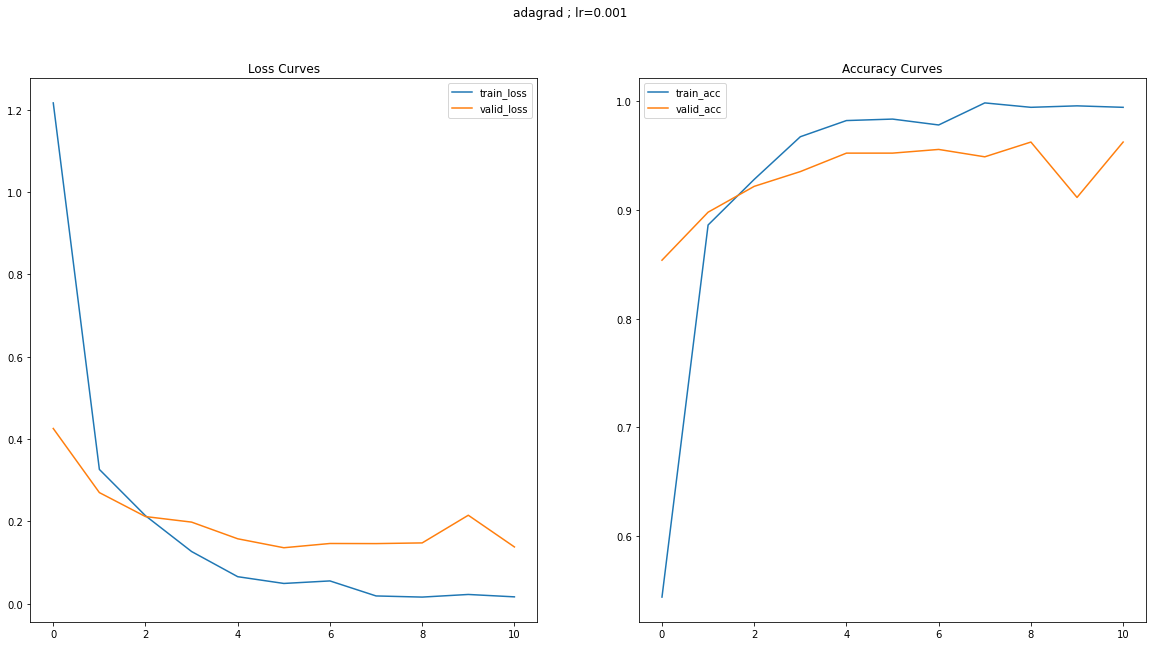

In [57]:
loss_acc_visuaize(history,optim="adagrad ; lr=0.001",path="../lr=0.001")

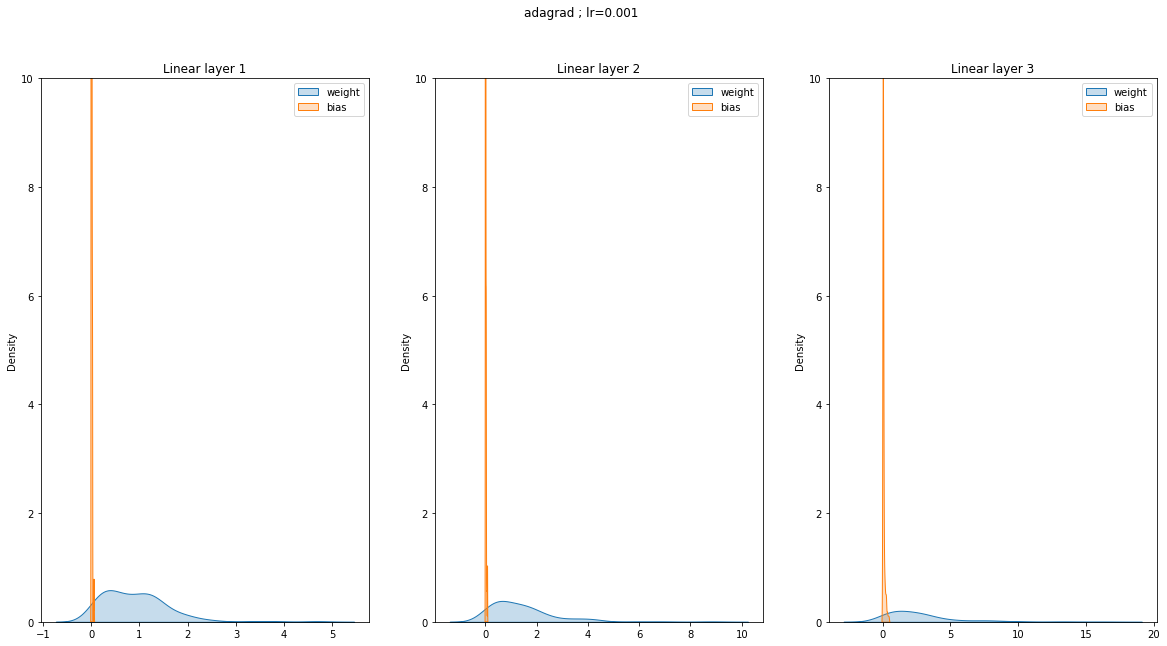

In [58]:
grad_visualize(history,optim="adagrad ; lr=0.001",path="../lr=0.001")

In [59]:
model = base_model_build()
model.load_state_dict(torch.load("../vgg16-transfer-adagrad-lr=0.001"))

training on gpu...


<All keys matched successfully>

tensor([[3.0626e-02, 3.6618e+00, 1.6268e-02, 5.6215e+02, 1.9434e-01]],
       device='cuda:0')


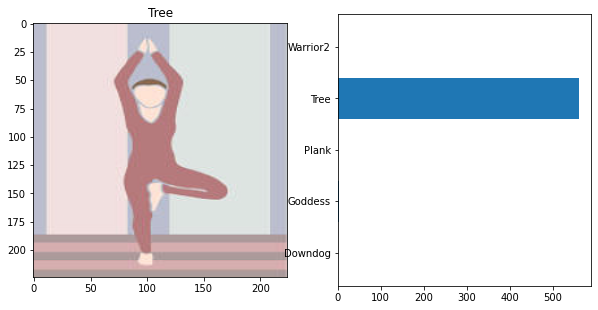

In [60]:
visual_predict(model)

In [61]:
adagrad_dict_lr001=class_accuracies(model)

Accuracy for class Downdog :  1.0
Accuracy for class Tree :  0.9322033898305084
Accuracy for class Plank :  1.0
Accuracy for class Warrior2 :  0.8813559322033898
Accuracy for class Goddess :  0.9152542372881356


In [62]:
# adagrad ; high learning rate

vgg16 = base_model_build()
optimizer_adam = optim.Adagrad(vgg16.classifier.parameters(), lr=0.05)

model=vgg16
criterion=criterion
optimizer=optimizer_adam
train_loader=train_loader
valid_loader=valid_loader
save_file_name='../vgg16-transfer-adagrad-lr=0.05'
max_epochs_stop=5
n_epochs=40
print_every=1

"""Train a PyTorch Model

Params
--------
    model (PyTorch model): cnn to train
    criterion (PyTorch loss): objective to minimize
    optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
    train_loader (PyTorch dataloader): training dataloader to iterate through
    valid_loader (PyTorch dataloader): validation dataloader used for early stopping
    save_file_name (str ending in '.pt'): file path to save the model state dict
    max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
    n_epochs (int): maximum number of training epochs
    print_every (int): frequency of epochs to print training stats

Returns
--------
    model (PyTorch model): trained cnn with best weights
    history (DataFrame): history of train and validation loss and accuracy
"""

# Early stopping intialization
epochs_no_improve = 0
valid_loss_min = np.Inf

valid_max_acc = 0
history = []
bias_grads1 = []
weight_grads1 = []
bias_grads2 = []
weight_grads2 = []
bias_grads3 = []
weight_grads3 = []


# Number of epochs already trained (if using loaded in model weights)
try:
    print(f'Model has been trained for: {model.epochs} epochs.\n')
except:
    model.epochs = 0
    print(f'Starting Training from Scratch.\n')

overall_start = timer()

# Main loop
for epoch in range(n_epochs):

    # keep track of training and validation loss each epoch
    train_loss = 0.0
    valid_loss = 0.0

    train_acc = 0
    valid_acc = 0

    # Set to training
    model.train()
    start = timer()

    # Training loop
    for ii, (data, target) in enumerate(train_loader):
        # Tensors to gpu
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Clear gradients
        optimizer.zero_grad()
        # Predicted outputs are log probabilities
        output = model(data)

        # Loss and backpropagation of gradients
        loss = criterion(output, target)
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        weight_grads1.append(np.linalg.norm(model.classifier[0].weight.grad.cpu().numpy()))
        bias_grads1.append(np.linalg.norm(model.classifier[0].bias.grad.cpu().numpy()))
        weight_grads2.append(np.linalg.norm(model.classifier[3].weight.grad.cpu().numpy()))
        bias_grads2.append(np.linalg.norm(model.classifier[3].bias.grad.cpu().numpy()))
        weight_grads3.append(np.linalg.norm(model.classifier[6].weight.grad.cpu().numpy()))
        bias_grads3.append(np.linalg.norm(model.classifier[6].bias.grad.cpu().numpy()))



        # Track train loss by multiplying average loss by number of examples in batch
        train_loss += loss.item() * data.size(0)

        # Calculate accuracy by finding max log probability
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        # Need to convert correct tensor from int to float to average
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples in batch
        train_acc += accuracy.item() * data.size(0)

        # Track training progress
        print(
            f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
            end='\r')

    # After training loops ends, start validation
    else:
        model.epochs += 1

        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for data, target in valid_loader:
                # Tensors to gpu
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                # Forward pass
                output = model(data)

                # Validation loss
                loss = criterion(output, target)
                # Multiply average loss times the number of examples in batch
                valid_loss += loss.item() * data.size(0)

                # Calculate validation accuracy
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))
                # Multiply average accuracy times the number of examples
                valid_acc += accuracy.item() * data.size(0)

            # Calculate average losses
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)

            # Calculate average accuracy
            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(valid_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            # Print training and validation results
            if (epoch + 1) % print_every == 0:
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                )

            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                # Save model
                torch.save(model.state_dict(), save_file_name)
                # Track improvement
                epochs_no_improve = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                # Trigger early stopping
                if epochs_no_improve >= max_epochs_stop:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                    )
                    total_time = timer() - overall_start
                    print(
                        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                    )

                    # Load the best state dict
                    model.load_state_dict(torch.load(save_file_name))
                    # Attach the optimizer
                    model.optimizer = optimizer

                    # Format history
                    history = pd.DataFrame(
                        history,
                        columns=[
                            'train_loss', 'valid_loss', 'train_acc',
                            'valid_acc'
                        ])
                    break

# Attach the optimizer
model.optimizer = optimizer
# Record overall time and print out stats
total_time = timer() - overall_start
print(
    f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
)
print(
    f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
)
# Format history
history = pd.DataFrame(
    history,
    columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

training on gpu...
Starting Training from Scratch.

Epoch: 0	100.00% complete. 11.64 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 18699.4385 	Validation Loss: 29.2877
		Training Accuracy: 22.36%	 Validation Accuracy: 68.03%
Epoch: 1	100.00% complete. 12.14 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 76.7464 	Validation Loss: 8.7840
		Training Accuracy: 68.70%	 Validation Accuracy: 84.69%
Epoch: 2	100.00% complete. 11.79 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 23.1007 	Validation Loss: 4.9575
		Training Accuracy: 77.37%	 Validation Accuracy: 87.41%
Epoch: 3	100.00% complete. 12.00 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 29.1183 	Validation Loss: 18.2713
		Training Accuracy: 81.57%	 Validation Accuracy: 80.61%
Epoch: 4	100.00% complete. 11.59 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 12.8818 	Validation Loss: 3.0482
		Training Accuracy: 85.64%	 Validation Accuracy: 90.82%
Epoch: 5	100.00% complete. 11.74 seconds elapsed in epoch.
Epoch: 5 	Trai

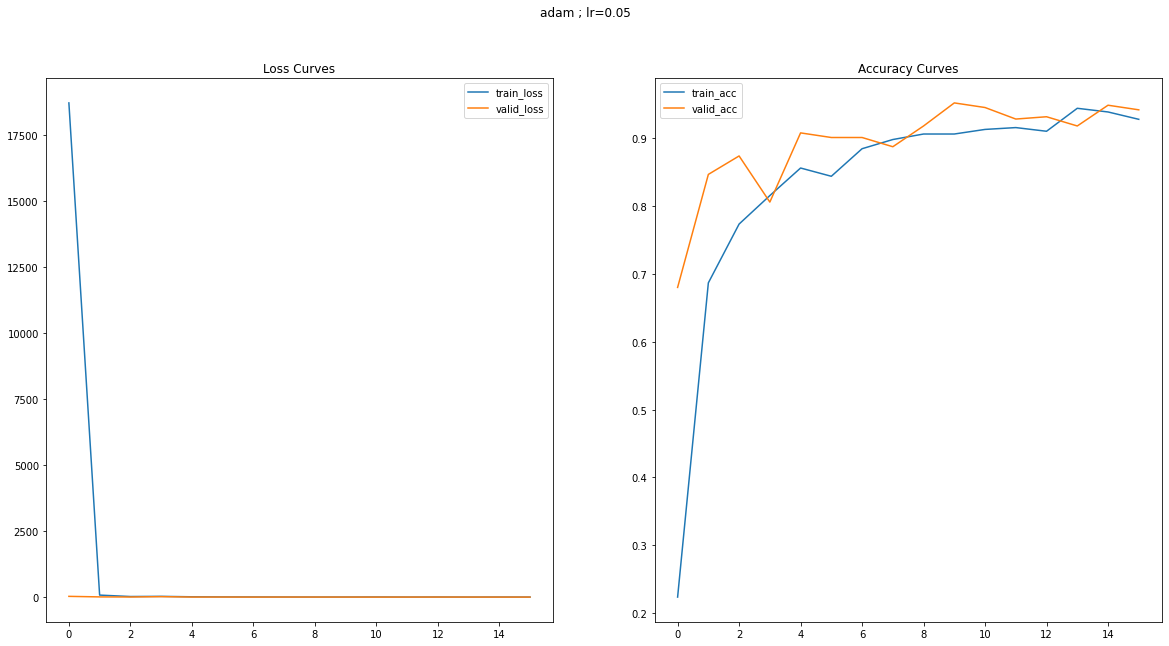

In [63]:
loss_acc_visuaize(history,optim="adam ; lr=0.05", path="../lr=0.05")

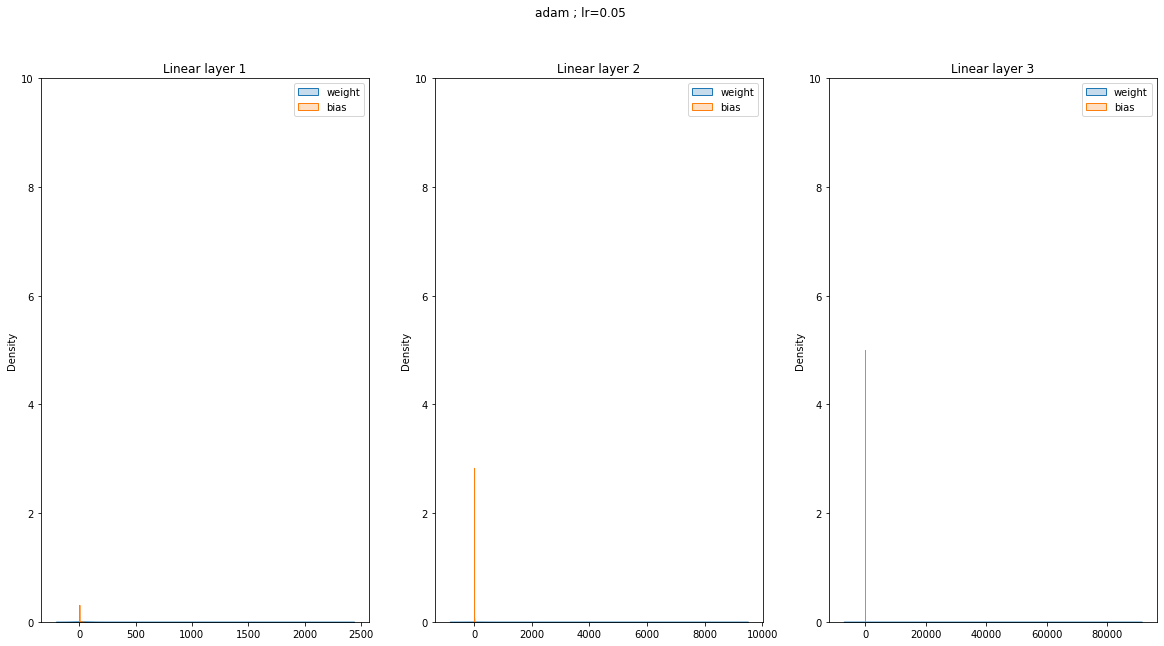

In [64]:
grad_visualize(history,optim="adam ; lr=0.05", path="../lr=0.05")

In [65]:
model = base_model_build()
model.load_state_dict(torch.load("../vgg16-transfer-adagrad-lr=0.05"))

training on gpu...


<All keys matched successfully>

tensor([[2.3577e+11, 5.7109e+11, 1.1973e+09, 2.5669e+20, 2.8381e+17]],
       device='cuda:0')


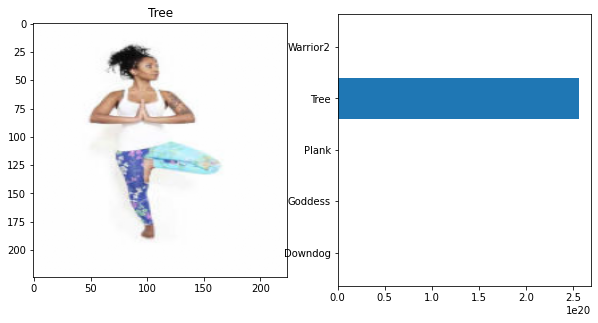

In [66]:
visual_predict(model)

In [67]:
adagrad_dict_lr05=class_accuracies(model)

Accuracy for class Downdog :  0.9655172413793104
Accuracy for class Tree :  0.6949152542372882
Accuracy for class Plank :  0.13559322033898305
Accuracy for class Warrior2 :  0.4915254237288136
Accuracy for class Goddess :  0.9491525423728814


### **class accuracies for different optimizers**

In [68]:
optims = ['sgd_lr001','sgd_lr05','adam_lr001','rmsprop_lr001','adagrad_lr001','adagrad_lr05']
classcounts = {}
for c in classes:
    classcounts[str(c)] = [sgd_lr001_dict[str(c)],sgd_lr05_dict[str(c)],adam_lr001_dict[str(c)],rmsprop_lr001_dict[str(c)],adagrad_dict_lr001[str(c)],adagrad_dict_lr05[str(c)]]

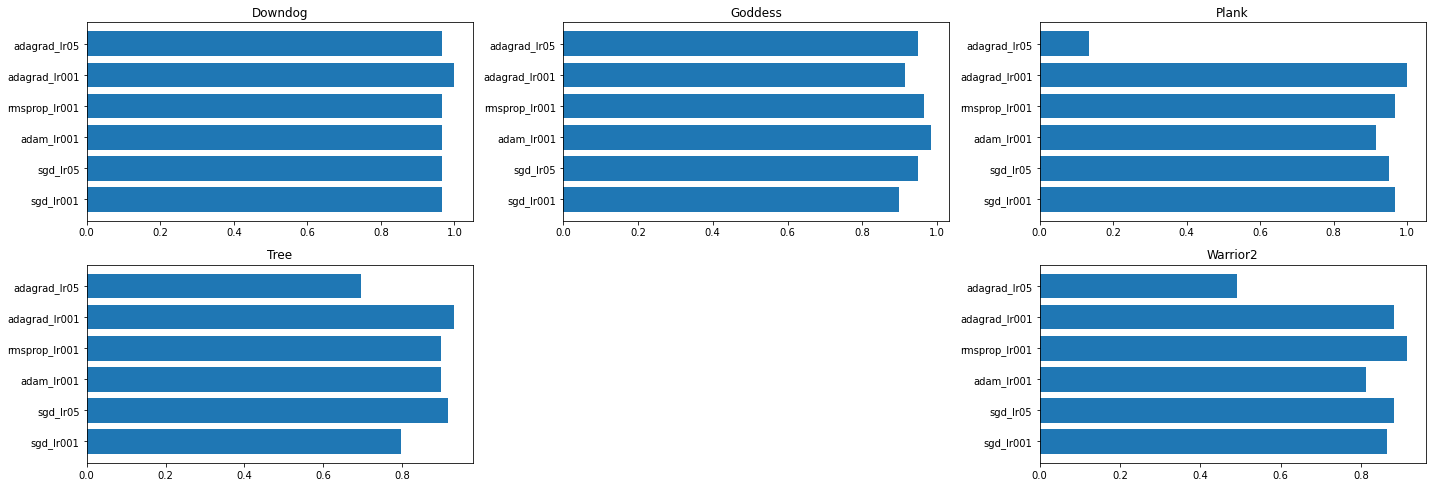

In [69]:
plt.figure(figsize=(20,10))

plt.subplot(331)
plt.barh(optims,classcounts['Downdog'])
plt.title('Downdog')

plt.subplot(332)
plt.barh(optims,classcounts['Goddess'])
plt.title('Goddess')

plt.subplot(333)
plt.barh(optims,classcounts['Plank'])
plt.title('Plank')

plt.subplot(334)
plt.barh(optims,classcounts['Tree'])
plt.title('Tree')

plt.subplot(336)
plt.barh(optims,classcounts['Warrior2'])
plt.title('Warrior2')

plt.tight_layout()